In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import data_read_and_prep as dc

from IPython.display import display

pd.options.display.max_columns = None

In [2]:
in_dir = r'D:\Documents\PythonDoc\FantasyFootball\new_data'
gameweek = 34
season_id = 's201819'

In [3]:
data_main = dc.raw_data_load(in_dir,
                  in_prefix='data_main_GW',
                  gameweek=gameweek,
                  season_id=season_id,
                  datetime_id='latest')

data_fixtures = dc.raw_data_load(in_dir,
                  in_prefix='data_fixtures_GW',
                  gameweek=gameweek,
                  season_id=season_id,
                  datetime_id='latest')

data_players_deep = dc.raw_data_load(in_dir,
                  in_prefix='data_players_deep_GW',
                  gameweek=gameweek,
                  season_id=season_id,
                  datetime_id='latest')

In [4]:
current_gw = data_main['current-event']
positions = pd.DataFrame(data_main['element_types'])
final_gw = data_main['last-entry-event']
next_gw = data_main['next-event']
fixtures = dc.get_fixtures(data_fixtures)
events = dc.get_events(data_main['events'])
next_events = dc.get_next_events(data_main['next_event_fixtures'])
teams = dc.get_teams(data_main['teams'])
player_summary = dc.get_players(data_main['elements'])
player_game_stats = dc.get_fixture_stats(data_fixtures)
player_history, player_future = dc.get_players_deep(data_players_deep)
total_players = data_main['total-players']

In [11]:
player_data = dc.clean_data(player_history,
               teams,
               fixtures,
               player_summary,
               positions,
               total_players,
               prev_matches_consider=3,
               gameweek_start=1,
               gameweek_end='latest')

In [12]:
player_data.head()

,player_id,first_name,second_name,position,team_id,team_short,team_name,team_difficulty,gameweek,kickoff_time,kickoff_hour,kickoff_hour_cos,kickoff_hour_sin,kickoff_hour_bin,kickoff_weekday,kickoff_weekday_cos,kickoff_weekday_sin,event_day,fixture_id,is_home,opponent_team,opponent_team_short,opponent_team_name,opponent_team_strength,opponent_difficulty,opponent_strength_ha_overall,opponent_strength_ha_attack,opponent_strength_ha_defence,target_total_points,target_minutes,target_goals_scored,target_goals_conceded,selected,value,value_change,custom_form,transfers_balance,transfers_in,transfers_out,team_strength,team_strength_ha_overall,team_strength_ha_attack,team_strength_ha_defence,chance_of_playing_this_round,chance_of_playing_next_round,status,news,prev_total_points,prev_minutes,prev_goals_scored,prev_bonus,prev_opponent_team,prev_assists,prev_attempted_passes,prev_big_chances_created,prev_big_chances_missed,prev_bps,prev_clean_sheets,prev_clearances_blocks_interceptions,prev_completed_passes,prev_creativity,prev_dribbles,prev_ea_index,prev_errors_leading_to_goal,prev_errors_leading_to_goal_attempt,prev_fouls,prev_goals_conceded,prev_ict_index,prev_playergw_id,prev_influence,prev_key_passes,prev_kickoff_time,prev_kickoff_time_formatted,prev_offside,prev_open_play_crosses,prev_own_goals,prev_penalties_conceded,prev_penalties_missed,prev_penalties_saved,prev_recoveries,prev_red_cards,prev_saves,prev_tackled,prev_tackles,prev_target_missed,prev_threat,prev_winning_goals,prev_yellow_cards,prev_team_score,prev_opponent_score,prev_win,prev_draw,prev_loss,kickoff_datetime,prev_kickoff_datetime,prev_kickoff_hour,prev_kickoff_hour_bin,prev_kickoff_weekday,prev_kickoff_hour_cos,prev_kickoff_hour_sin,prev_kickoff_weekday_cos,prev_kickoff_weekday_sin,team_prev_result_points,team_prev_mean_points,team_prev_total_points,team_prev_unique_scorers,roll_team_scored,roll_team_conceded,roll_team_points,roll_unique_scorers,roll_mean_points,roll_total_points,roll_minutes,roll_goals_scored
0,1,Petr,Cech,GKP,1,ARS,Arsenal,4,1,2018-08-12T15:00:00Z,15,-0.707107,-7.071068e-01,afternoon,6,0.623490,-0.781831,3,1,True,13,MCI,Man City,5.0,4,1320.0,1320.0,1340.0,3.0,90.0,0.0,2.0,70767.0,50.0,NaN,NaN,0.0,0.0,0.0,4.0,1260.0,1240.0,1310.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,2018-08-12 15:00:00,NaT,NaN,evening,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Petr,Cech,GKP,1,ARS,Arsenal,4,2,2018-08-18T16:30:00Z,16,-0.500000,-8.660254e-01,afternoon,5,-0.222521,-0.974928,1,14,False,6,CHE,Chelsea,4.0,4,1310.0,1340.0,1330.0,3.0,90.0,0.0,3.0,90038.0,50.0,0.0,NaN,188.0,6059.0,5871.0,4.0,1320.0,1270.0,1340.0,NaN,NaN,NaN,NaN,3.0,90.0,0.0,0.0,13.0,0.0,42.0,0.0,0.0,24.0,0.0,2.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.7,1.0,47.0,0.0,2018-08-12T15:00:00Z,12 Aug 16:00,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,False,False,True,2018-08-18 16:30:00,2018-08-12 15:00:00,15.0,afternoon,6.0,-0.707107,-7.071068e-01,0.623490,-0.781831,0.0,1.357143,19.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,Petr,Cech,GKP,1,ARS,Arsenal,3,3,2018-08-25T14:00:00Z,14,-0.866025,-5.000000e-01,midday,5,-0.222521,-0.974928,1,21,True,19,WHU,West Ham,3.0,4,1100.0,1090.0,1120.0,3.0,90.0,0.0,1.0,107301.0,50.0,0.0,NaN,8540.0,19550.0,11010.0,4.0,1260.0,1240.0,1310.0,NaN,NaN,NaN,NaN,3.0,90.0,0.0,0.0,6.0,0.0,35.0,0.0,0.0,26.0,0.0,1.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.3,526.0,53.0,0.0,2018-08-18T16:30:00Z,18 Aug 17:30,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,False,False,True,2018-08-25 14:00:00,2018-08-18 16:30:00,16.0,afternoon,5.0,-0.500000,-8.660254e-01,-0.222521,-0.974928,0.0,2.428571,34.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,Petr,Cech,GKP,1,ARS,Arsenal,2,4,2018-09-02T12:30:00Z,12,-1.000000,1.224647e-16,midday,6,0.623490,-0.781831,2,33,False,5,CAR,Cardiff,2.0,4,1080.0,106

In [13]:
player_data.shape

(19689, 114)

In [14]:
player_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19689 entries, 0 to 19688
Columns: 114 entries, player_id to roll_goals_scored
dtypes: bool(4), category(19), datetime64[ns](2), float64(80), int64(2), object(7)
memory usage: 15.1+ MB


In [15]:
safe = player_data.copy()

In [16]:
player_data = safe.copy()

## Splitting the data

I'm going to start by using a simple splitting scheme, with 20% of the initial data going into a test set to be used to evaluate the final model. The remainder will be split into a training set (80%) to build a selection of models with different hyperparameters, and a validation set (20%) to compare between them.

In the future it would be good to do nested cross-validation, but for simplicity, and the fact we have roughly 20,000 player-games I will start off using the aforementioned approach.

https://stats.stackexchange.com/questions/291368/how-to-split-dataset-for-model-selection-and-tuning
https://stats.stackexchange.com/questions/64991/model-selection-and-cross-validation-the-right-way?rq=1
https://stats.stackexchange.com/questions/64147/internal-vs-external-cross-validation-and-model-selection
https://towardsdatascience.com/a-short-introduction-to-model-selection-bb1bb9c73376
https://stats.stackexchange.com/questions/65128/nested-cross-validation-for-model-selection?rq=1
https://stats.stackexchange.com/questions/244907/how-to-get-hyper-parameters-in-nested-cross-validation?noredirect=1&lq=1

In [9]:
test_fraction = 0.2
val_fraction = 0.2

from sklearn.model_selection import train_test_split

player_ids = player_data['player_id'].unique().astype(int)
player_ids_train, player_ids_test = train_test_split(player_ids, test_size=test_fraction)
player_ids_train, player_ids_val = train_test_split(player_ids_train, test_size=val_fraction)

print('Number of players per split:')
print('Train: {:.0f}'.format(len(player_ids_train)))
print('Validation: {:.0f}'.format(len(player_ids_val)))
print('Test: {:.0f}'.format(len(player_ids_test)))

print('\nPercentage of players per split:')
print('Train: {:.1%}'.format(len(player_ids_train)/len(player_ids)))
print('Validation: {:.1%}'.format(len(player_ids_val)/len(player_ids)))
print('Test: {:.1%}'.format(len(player_ids_test)/len(player_ids)))

Number of players per split:
Train: 391
Validation: 98
Test: 123

Percentage of players per split:
Train: 63.9%
Validation: 16.0%
Test: 20.1%


While the numbers per split appear low, we have 30 plus games per player. The process above ensures that we do not have individual players appearing in multiple splits (which could cause severe overfitting).

However, we need to add a variable to our main data to show which split each row is in.

In [10]:
player_data['split'] = np.where(player_data['player_id'].isin(player_ids_train), 'TRAIN',
                               np.where(player_data['player_id'].isin(player_ids_val), 'VAL', 'TEST'))

My approach is to do the necessary basic cleaning (i.e. that will not bleed test information into the training datasets such as one hot encoding) on the full data. Then I will use the training data only to explore the data in more depth for feature cleaning and selection.

I have added already added new features and done some cleaning in the functions above, however, these are independent across rows so will not lead to optimistic model evaluation metrics. A couple of examples are splitting kickoff datetimes into components, adding player position data and team stats, and 'rolling'/previous stats for each player.

Data cleaning and feature engineering which could jeopardise the model evaluation through data leakage will be done after the data has been split. For example, imputation of missing values will be done for the whole data based upon, for example, means found in the training set only.

In [11]:
player_data.head()

,player_id,first_name,second_name,position,team_id,team_short,team_name,team_difficulty,gameweek,kickoff_time,kickoff_hour,kickoff_hour_cos,kickoff_hour_sin,kickoff_hour_bin,kickoff_weekday,kickoff_weekday_cos,kickoff_weekday_sin,event_day,fixture_id,is_home,opponent_team,opponent_team_short,opponent_team_name,opponent_team_strength,opponent_difficulty,opponent_strength_ha_overall,opponent_strength_ha_attack,opponent_strength_ha_defence,target_total_points,target_minutes,target_goals_scored,target_goals_conceded,selected,value,value_change,custom_form,transfers_balance,transfers_in,transfers_out,team_strength,team_strength_ha_overall,team_strength_ha_attack,team_strength_ha_defence,chance_of_playing_this_round,chance_of_playing_next_round,status,news,prev_total_points,prev_minutes,prev_goals_scored,prev_bonus,prev_opponent_team,prev_assists,prev_attempted_passes,prev_big_chances_created,prev_big_chances_missed,prev_bps,prev_clean_sheets,prev_clearances_blocks_interceptions,prev_completed_passes,prev_creativity,prev_dribbles,prev_ea_index,prev_errors_leading_to_goal,prev_errors_leading_to_goal_attempt,prev_fouls,prev_goals_conceded,prev_ict_index,prev_playergw_id,prev_influence,prev_key_passes,prev_kickoff_time,prev_kickoff_time_formatted,prev_offside,prev_open_play_crosses,prev_own_goals,prev_penalties_conceded,prev_penalties_missed,prev_penalties_saved,prev_recoveries,prev_red_cards,prev_saves,prev_tackled,prev_tackles,prev_target_missed,prev_threat,prev_winning_goals,prev_yellow_cards,prev_team_score,prev_opponent_score,prev_win,prev_draw,prev_loss,kickoff_datetime,prev_kickoff_datetime,prev_kickoff_hour,prev_kickoff_hour_bin,prev_kickoff_weekday,prev_kickoff_hour_cos,prev_kickoff_hour_sin,prev_kickoff_weekday_cos,prev_kickoff_weekday_sin,team_prev_result_points,team_prev_mean_points,team_prev_total_points,team_prev_unique_scorers,roll_team_scored,roll_team_conceded,roll_team_points,roll_unique_scorers,roll_mean_points,roll_total_points,roll_minutes,roll_goals_scored,split
0,1,Petr,Cech,GKP,1,ARS,Arsenal,4,1,2018-08-12T15:00:00Z,15,-0.707107,-7.071068e-01,afternoon,6,0.623490,-0.781831,3,1,True,13,MCI,Man City,5.0,4,1320.0,1320.0,1340.0,3.0,90.0,0.0,2.0,70767.0,50.0,NaN,NaN,0.0,0.0,0.0,4.0,1260.0,1240.0,1310.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,2018-08-12 15:00:00,NaT,NaN,evening,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRAIN
1,1,Petr,Cech,GKP,1,ARS,Arsenal,4,2,2018-08-18T16:30:00Z,16,-0.500000,-8.660254e-01,afternoon,5,-0.222521,-0.974928,1,14,False,6,CHE,Chelsea,4.0,4,1310.0,1340.0,1330.0,3.0,90.0,0.0,3.0,90038.0,50.0,0.0,NaN,188.0,6059.0,5871.0,4.0,1320.0,1270.0,1340.0,NaN,NaN,NaN,NaN,3.0,90.0,0.0,0.0,13.0,0.0,42.0,0.0,0.0,24.0,0.0,2.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.7,1.0,47.0,0.0,2018-08-12T15:00:00Z,12 Aug 16:00,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,False,False,True,2018-08-18 16:30:00,2018-08-12 15:00:00,15.0,afternoon,6.0,-0.707107,-7.071068e-01,0.623490,-0.781831,0.0,1.357143,19.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRAIN
2,1,Petr,Cech,GKP,1,ARS,Arsenal,3,3,2018-08-25T14:00:00Z,14,-0.866025,-5.000000e-01,midday,5,-0.222521,-0.974928,1,21,True,19,WHU,West Ham,3.0,4,1100.0,1090.0,1120.0,3.0,90.0,0.0,1.0,107301.0,50.0,0.0,NaN,8540.0,19550.0,11010.0,4.0,1260.0,1240.0,1310.0,NaN,NaN,NaN,NaN,3.0,90.0,0.0,0.0,6.0,0.0,35.0,0.0,0.0,26.0,0.0,1.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,5.3,526.0,53.0,0.0,2018-08-18T16:30:00Z,18 Aug 17:30,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,False,False,True,2018-08-25 14:00:00,2018-08-18 16:30:00,16.0,afternoon,5.0,-0.500000,-8.660254e-01,-0.222521,-0.974928,0.0,2.428571,34.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRAIN
3,1,Petr,Cech,GKP,1,ARS,Arsenal,2,4,2018-09-02T12:30:00Z,12,-1.000000,1.224647e-16,midday,6,0.623490,-0.781831,2,33,False,5,CAR,

First there are a few categorical data columns in our dataset, including a few masquerading as numeric columns! We need to convert these to numeric, the quickest way being to one hot encode them. However, I did have designs on trying out some multilevel models so I will make copies of a few of the originals rather than replace them. Some algorithm implementations (such as Distributed Random Forests in H2O can handle categorical data directly. Thankfully, the cardinality of encoded columns is not that high so for now I will follow the simple approach.
Some of the categorical columns to consider are:
* **position**: o.h.e.
* **team_short**: o.h.e. or try as random effect in a mixed model (though only twenty teams). Another alternative might be to make this ordinal by using position in the league table - however, this would require constructing the table.
* **event_day**: ordinal but no guarantee this varies linearly with the target. As this has only three (or maybe four levels) it is fine to o.h.e.
* **opponent_team_short**: similar to team

Note some of the categorical columns I do not plan to use. For example, kickoff_hour_bin was replaced by the cyclic kickoff_hour_sin and kickoff_hour_cos columns.

In [12]:
columns_to_ohe = ['position',
                 'team_short',
                 'event_day',
                 'opponent_team_short']

player_data[['orig_' + col for col in columns_to_ohe]] = player_data[columns_to_ohe]
# player_data[['orig_team_short', 'orig_opponent_team_short']] = player_data[['team_short', 'opponent_team_short']]

player_data = pd.get_dummies(player_data, columns=columns_to_ohe)

Next I will drop the columns no longer needed. These are mostly reference columns (such as player names) or those already used to create new features (such as the kickoff datatime).

In [13]:
# Columns to be dropped from the data 
drop_cols = ['first_name',
            'second_name',
            'team_id',
            'team_name',
            'kickoff_time',
            'kickoff_hour',
            'kickoff_hour_bin',
            'kickoff_weekday',
            'fixture_id',
            'opponent_team',
            'opponent_team_name',
            'prev_kickoff_time',
            'prev_kickoff_hour',
            'prev_kickoff_hour_bin',
            'prev_kickoff_weekday',
            'prev_kickoff_time_formatted',
            'kickoff_datetime',
            'prev_kickoff_datetime'
            ]

# Columns which I added on separately from my earlier weekly saved datasets. These have many more missing values and are a bit
# unreliable (except for the next gameweek which is always as up-to-date as this data is) so will not be used. I will keep them
# in as the latest values may be used for other purposes such as deciding whether a player is likely to play.
sparse_cols = ['chance_of_playing_this_round',
               'chance_of_playing_next_round',
               'status',
               'news',]

# These are the columns I built to predict values for. I will mostly use the first two.
target_cols = [ 'target_total_points',
                'target_minutes',
                'target_goals_scored',
                'target_goals_conceded']

# These are columns which under no circumstances will be used in the main model process
non_model_cols = ['player_id',
                 'gameweek'] + sparse_cols + target_cols

player_data.drop(columns=drop_cols, inplace=True)

In [14]:
player_data.head()

,player_id,team_difficulty,gameweek,kickoff_hour_cos,kickoff_hour_sin,kickoff_weekday_cos,kickoff_weekday_sin,is_home,opponent_team_strength,opponent_difficulty,opponent_strength_ha_overall,opponent_strength_ha_attack,opponent_strength_ha_defence,target_total_points,target_minutes,target_goals_scored,target_goals_conceded,selected,value,value_change,custom_form,transfers_balance,transfers_in,transfers_out,team_strength,team_strength_ha_overall,team_strength_ha_attack,team_strength_ha_defence,chance_of_playing_this_round,chance_of_playing_next_round,status,news,prev_total_points,prev_minutes,prev_goals_scored,prev_bonus,prev_opponent_team,prev_assists,prev_attempted_passes,prev_big_chances_created,prev_big_chances_missed,prev_bps,prev_clean_sheets,prev_clearances_blocks_interceptions,prev_completed_passes,prev_creativity,prev_dribbles,prev_ea_index,prev_errors_leading_to_goal,prev_errors_leading_to_goal_attempt,prev_fouls,prev_goals_conceded,prev_ict_index,prev_playergw_id,prev_influence,prev_key_passes,prev_offside,prev_open_play_crosses,prev_own_goals,prev_penalties_conceded,prev_penalties_missed,prev_penalties_saved,prev_recoveries,prev_red_cards,prev_saves,prev_tackled,prev_tackles,prev_target_missed,prev_threat,prev_winning_goals,prev_yellow_cards,prev_team_score,prev_opponent_score,prev_win,prev_draw,prev_loss,prev_kickoff_hour_cos,prev_kickoff_hour_sin,prev_kickoff_weekday_cos,prev_kickoff_weekday_sin,team_prev_result_points,team_prev_mean_points,team_prev_total_points,team_prev_unique_scorers,roll_team_scored,roll_team_conceded,roll_team_points,roll_unique_scorers,roll_mean_points,roll_total_points,roll_minutes,roll_goals_scored,split,orig_position,orig_team_short,orig_event_day,orig_opponent_team_short,position_DEF,position_FWD,position_GKP,position_MID,team_short_ARS,team_short_BHA,team_short_BOU,team_short_BUR,team_short_CAR,team_short_CHE,team_short_CRY,team_short_EVE,team_short_FUL,team_short_HUD,team_short_LEI,team_short_LIV,team_short_MCI,team_short_MUN,team_short_NEW,team_short_SOU,team_short_TOT,team_short_WAT,team_short_WHU,team_short_WOL,event_day_1,event_day_2,event_day_3,event_day_4,event_day_5,opponent_team_short_ARS,opponent_team_short_BHA,opponent_team_short_BOU,opponent_team_short_BUR,opponent_team_short_CAR,opponent_team_short_CHE,opponent_team_short_CRY,opponent_team_short_EVE,opponent_team_short_FUL,opponent_team_short_HUD,opponent_team_short_LEI,opponent_team_short_LIV,opponent_team_short_MCI,opponent_team_short_MUN,opponent_team_short_NEW,opponent_team_short_SOU,opponent_team_short_TOT,opponent_team_short_WAT,opponent_team_short_WHU,opponent_team_short_WOL
0,1,4,1,-0.707107,-7.071068e-01,0.623490,-0.781831,True,5.0,4,1320.0,1320.0,1340.0,3.0,90.0,0.0,2.0,70767.0,50.0,NaN,NaN,0.0,0.0,0.0,4.0,1260.0,1240.0,1310.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRAIN,GKP,ARS,3,MCI,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,4,2,-0.500000,-8.660254e-01,-0.222521,-0.974928,False,4.0,4,1310.0,1340.0,1330.0,3.0,90.0,0.0,3.0,90038.0,50.0,0.0,NaN,188.0,6059.0,5871.0,4.0,1320.0,1270.0,1340.0,NaN,NaN,NaN,NaN,3.0,90.0,0.0,0.0,13.0,0.0,42.0,0.0,0.0,24.0,0.0,2.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.7,1.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,False,False,True,-0.707107,-7.071068e-01,0.623490,-0.781831,0.0,1.357143,19.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRAIN,GKP,ARS,1,CHE,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,3,3,-0.866025,-5.000000e-01,-0.222521,-0.974928,True,3.0,4,1100.0,1090.0,1120.0,3.0,90.0,0.0,1.0,107301.0,50.0,0.0,NaN,8540.0,19550.0,11010.0,4.0,1260.0,1240.0,1310.0,NaN,NaN,NaN,NaN,3.0,90.0,0.0,0.0,6.0,0.0,35.0,0.0,0.0,26.0,0.0,1.0,25.0,0

Now to split the data.

In [15]:
data_train = player_data.loc[player_data['split']=='TRAIN', :].copy()
data_val = player_data.loc[player_data['split']=='VAL', :].copy()
data_test = player_data.loc[player_data['split']=='TEST', :].copy()

---

Before continuing with our main feature processing, now is a good time to look at the disrtibution of the target variable so we can decide the approach. I am in quite a flexible situation in that I am open to the type of model used - all I want to do is identify players likely to score highly. I could take three approaches:
* **linear regression**: modelling the number of points as a continuous variable
* **Poisson regression**: modelling the number of points as a discrete count variable. I envisage a couple of issues with this. Firstly, lots of players do not play or otherwise receive zero points, which is not supported by these kinds of models (this will to a smaller extent affect linear regression). We can get around this by using zero-inflated models. Secondly, players can receive negative points which is a bit more difficult to take care of.
* **classification**: we could turn this into a problem of classification where we look to predict points above a certain threshold. This might be an easier approach due to the number of zeros (and negatives) in the target variable. However, we would need to select a threshold and, from experience, most players which play recieve between 1 and 3 points, suggesting an unbalanced dataset.

First, in our training set, what do the numbers of points look like?

In [16]:
min_points = data_train['target_total_points'].min()
print('Min points in a game: {}'.format(min_points))

max_points = data_train['target_total_points'].max()
print('Max points in a game: {}'.format(max_points))

Min points in a game: -3.0
Max points in a game: 23.0


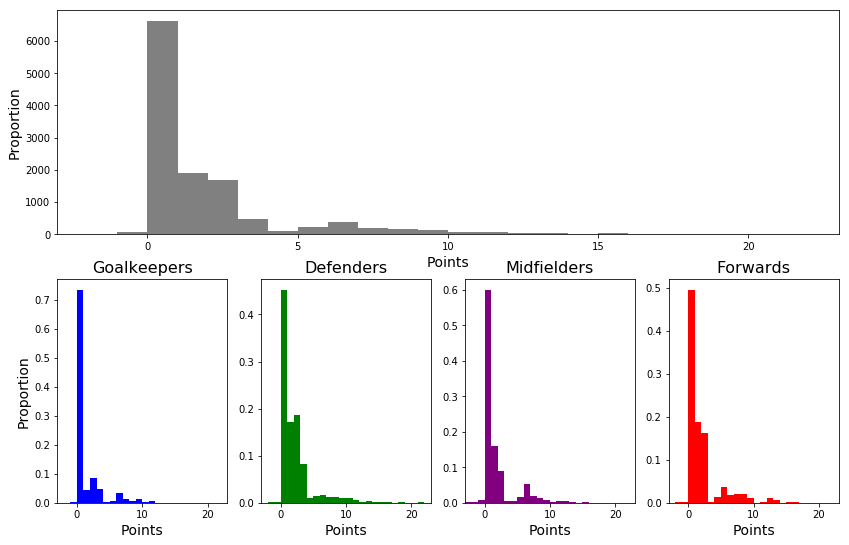

In [17]:
#fig = plt.subplots(3,4, figsize=(10,10))
fig = plt.figure(figsize=(14,14))

# Get histogram bins from integers between the min and max points
#nbins = int(max_points-min_points + 1)
nbins = np.arange(min_points, max_points+1)

# Subplots for all players, and then broken down by position
ax_all = plt.subplot2grid((3,4), (0,0), colspan=4)
ax_gkp = plt.subplot2grid((3,4), (1,0))
ax_def = plt.subplot2grid((3,4), (1,1))
ax_mid = plt.subplot2grid((3,4), (1,2))
ax_for = plt.subplot2grid((3,4), (1,3))

ax_all.hist(data_train['target_total_points'].dropna(), bins=nbins, color='grey')
ax_gkp.hist(data_train.loc[data_train['position_GKP']==1,'target_total_points'].dropna(), bins=nbins, color='blue', density=True)
ax_mid.hist(data_train.loc[data_train['position_DEF']==1,'target_total_points'].dropna(), bins=nbins, color='purple', density=True)
ax_def.hist(data_train.loc[data_train['position_MID']==1,'target_total_points'].dropna(), bins=nbins, color='green', density=True)
ax_for.hist(data_train.loc[data_train['position_FWD']==1,'target_total_points'].dropna(), bins=nbins, color='red', density=True)

ax_gkp.set_title('Goalkeepers', fontsize=16)
ax_def.set_title('Defenders', fontsize=16)
ax_mid.set_title('Midfielders', fontsize=16)
ax_for.set_title('Forwards', fontsize=16)

for ax in [ax_all, ax_gkp, ax_def, ax_mid, ax_for]:
    ax.set_xlim(min_points, max_points)
    ax.set_xlabel('Points', fontsize=14)

ax_all.set_ylabel('Proportion', fontsize=14)
ax_gkp.set_ylabel('Proportion', fontsize=14)

plt.show()

We can see some bimodality in the target variable. Note, however, there are lots of players who do not play in each game.

In [18]:
data_train['played_at_all'] = data_train['target_minutes']>0

data_train.groupby('played_at_all').size()

played_at_all
False    6741
True     5851
dtype: int64

Roughly half of players do not play any minutes. Let's see what happens when we take these out.

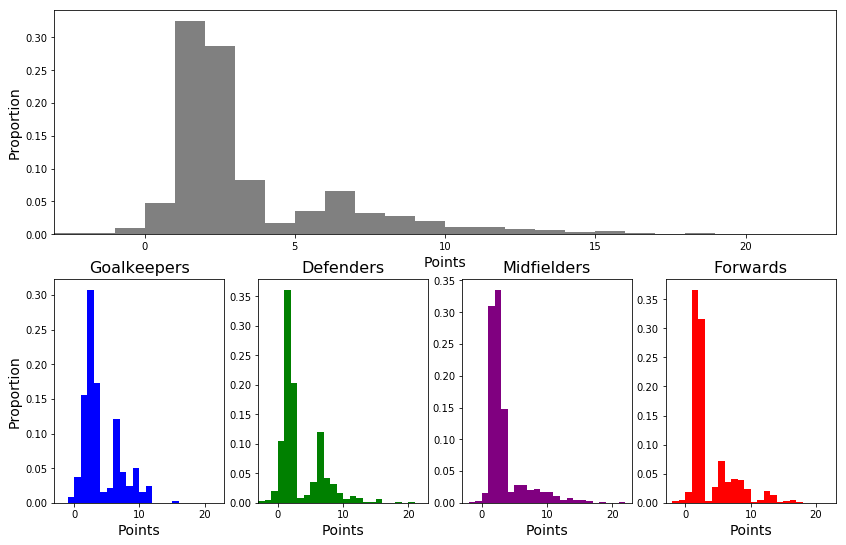

In [19]:
#fig = plt.subplots(3,4, figsize=(10,10))
fig = plt.figure(figsize=(14,14))

ax_all = plt.subplot2grid((3,4), (0,0), colspan=4)
ax_gkp = plt.subplot2grid((3,4), (1,0))
ax_def = plt.subplot2grid((3,4), (1,1))
ax_mid = plt.subplot2grid((3,4), (1,2))
ax_for = plt.subplot2grid((3,4), (1,3))

ax_all.hist(data_train.loc[data_train['played_at_all'],'target_total_points'].dropna(), bins=nbins, color='grey', density=True)
ax_gkp.hist(data_train.loc[(data_train['position_GKP']==1) &
                            (data_train['played_at_all']),'target_total_points'].dropna(), bins=nbins, color='blue', density=True)
ax_def.hist(data_train.loc[(data_train['position_DEF']==1) &
                            (data_train['played_at_all']),'target_total_points'].dropna(), bins=nbins, color='green', density=True)
ax_mid.hist(data_train.loc[(data_train['position_MID']==1) &
                            (data_train['played_at_all']),'target_total_points'].dropna(), bins=nbins, color='purple', density=True)
ax_for.hist(data_train.loc[(data_train['position_FWD']==1) &
                            (data_train['played_at_all']),'target_total_points'].dropna(), bins=nbins, color='red', density=True)

ax_gkp.set_title('Goalkeepers', fontsize=16)
ax_def.set_title('Defenders', fontsize=16)
ax_mid.set_title('Midfielders', fontsize=16)
ax_for.set_title('Forwards', fontsize=16)

for ax in [ax_all, ax_gkp, ax_def, ax_mid, ax_for]:
    ax.set_xlim(min_points, max_points)
    ax.set_xlabel('Points', fontsize=14)

ax_all.set_ylabel('Proportion', fontsize=14)
ax_gkp.set_ylabel('Proportion', fontsize=14)

plt.show()

The bimodality is even clearer. Looking at this, it might be useful to perform binary classification on whether or not a player will get more than 4 points in a game. We do have the issue of unbalanced data, but this will be slightly less of an issue if we were to have a variable saying/predicting whether a player is to play.

One of the other options was to use Poisson regression to model the discrete number of points directly. However, we have several problems. From above, players can get negative points and there are many zeros. We also have clear bimodality. Finally, a key assumption of Poisson regression is that the mean and variance of the response are equal. This is not the case with our data:

In [20]:
print('Mean: {:.2f}'.format(data_train.loc[data_train['target_minutes']>0,'target_total_points'].mean()))
print('Variance: {:.2f}'.format(data_train.loc[data_train['target_minutes']>0,'target_total_points'].var()))

Mean: 2.98
Variance: 9.40


We could look into negative binomial regression to address this. However, the multitude of violated assumptions will require lots of effort to overcome, so maybe this is more something for the future...

### Relationships between features and the response
Before performing any transformations, I want to check how our numeric variables are associated with the response in our training dataset. This will help highlight whether linear regression is a path to take (i.e. if the relationships are linear etcetera).

A reminder of the data:

In [21]:
data_train.head()

,player_id,team_difficulty,gameweek,kickoff_hour_cos,kickoff_hour_sin,kickoff_weekday_cos,kickoff_weekday_sin,is_home,opponent_team_strength,opponent_difficulty,opponent_strength_ha_overall,opponent_strength_ha_attack,opponent_strength_ha_defence,target_total_points,target_minutes,target_goals_scored,target_goals_conceded,selected,value,value_change,custom_form,transfers_balance,transfers_in,transfers_out,team_strength,team_strength_ha_overall,team_strength_ha_attack,team_strength_ha_defence,chance_of_playing_this_round,chance_of_playing_next_round,status,news,prev_total_points,prev_minutes,prev_goals_scored,prev_bonus,prev_opponent_team,prev_assists,prev_attempted_passes,prev_big_chances_created,prev_big_chances_missed,prev_bps,prev_clean_sheets,prev_clearances_blocks_interceptions,prev_completed_passes,prev_creativity,prev_dribbles,prev_ea_index,prev_errors_leading_to_goal,prev_errors_leading_to_goal_attempt,prev_fouls,prev_goals_conceded,prev_ict_index,prev_playergw_id,prev_influence,prev_key_passes,prev_offside,prev_open_play_crosses,prev_own_goals,prev_penalties_conceded,prev_penalties_missed,prev_penalties_saved,prev_recoveries,prev_red_cards,prev_saves,prev_tackled,prev_tackles,prev_target_missed,prev_threat,prev_winning_goals,prev_yellow_cards,prev_team_score,prev_opponent_score,prev_win,prev_draw,prev_loss,prev_kickoff_hour_cos,prev_kickoff_hour_sin,prev_kickoff_weekday_cos,prev_kickoff_weekday_sin,team_prev_result_points,team_prev_mean_points,team_prev_total_points,team_prev_unique_scorers,roll_team_scored,roll_team_conceded,roll_team_points,roll_unique_scorers,roll_mean_points,roll_total_points,roll_minutes,roll_goals_scored,split,orig_position,orig_team_short,orig_event_day,orig_opponent_team_short,position_DEF,position_FWD,position_GKP,position_MID,team_short_ARS,team_short_BHA,team_short_BOU,team_short_BUR,team_short_CAR,team_short_CHE,team_short_CRY,team_short_EVE,team_short_FUL,team_short_HUD,team_short_LEI,team_short_LIV,team_short_MCI,team_short_MUN,team_short_NEW,team_short_SOU,team_short_TOT,team_short_WAT,team_short_WHU,team_short_WOL,event_day_1,event_day_2,event_day_3,event_day_4,event_day_5,opponent_team_short_ARS,opponent_team_short_BHA,opponent_team_short_BOU,opponent_team_short_BUR,opponent_team_short_CAR,opponent_team_short_CHE,opponent_team_short_CRY,opponent_team_short_EVE,opponent_team_short_FUL,opponent_team_short_HUD,opponent_team_short_LEI,opponent_team_short_LIV,opponent_team_short_MCI,opponent_team_short_MUN,opponent_team_short_NEW,opponent_team_short_SOU,opponent_team_short_TOT,opponent_team_short_WAT,opponent_team_short_WHU,opponent_team_short_WOL,played_at_all
0,1,4,1,-0.707107,-7.071068e-01,0.623490,-0.781831,True,5.0,4,1320.0,1320.0,1340.0,3.0,90.0,0.0,2.0,70767.0,50.0,NaN,NaN,0.0,0.0,0.0,4.0,1260.0,1240.0,1310.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRAIN,GKP,ARS,3,MCI,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,True
1,1,4,2,-0.500000,-8.660254e-01,-0.222521,-0.974928,False,4.0,4,1310.0,1340.0,1330.0,3.0,90.0,0.0,3.0,90038.0,50.0,0.0,NaN,188.0,6059.0,5871.0,4.0,1320.0,1270.0,1340.0,NaN,NaN,NaN,NaN,3.0,90.0,0.0,0.0,13.0,0.0,42.0,0.0,0.0,24.0,0.0,2.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.7,1.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,False,False,True,-0.707107,-7.071068e-01,0.623490,-0.781831,0.0,1.357143,19.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRAIN,GKP,ARS,1,CHE,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True
2,1,3,3,-0.866025,-5.000000e-01,-0.222521,-0.974928,True,3.0,4,1100.0,1090.0,1120.0,3.0,90.0,0.0,1.0,107301.0,50.0,0.0,NaN,8540.0,19550.0,11010.0,4.0,1260.0,1240.0,1310.0,NaN,NaN,NaN,NaN,3.0,90.0,0.0,0.0,6.0,0.0,35.0,0.0

The rolling/previous columns require three or one past match per player to have a value. For this reason, I will only consider players' matches from match four onwards. As we can have problems with players appearing midway through the season, I will mark those players without the required data (so as to highlight the matches are in the first three for that player).

In [22]:
# These two columns represent the data which will be missing for players' initial gameweeks
data_train['use_row'] = ~data_train['roll_team_scored'].isna() &\
~data_train['prev_key_passes'].isna() &\
~data_train['custom_form'].isna()

I will also split the features into three so it will be easier to display relationships.

In [23]:
# Columns with general information about the player's stats, gameweek opponents, and team and previous team stats 
feature_cols_rels1 = ['team_difficulty',
                         'kickoff_hour_cos',
                         'kickoff_hour_sin',
                         'kickoff_weekday_cos',
                         'kickoff_weekday_sin',
                         'is_home',
                         'opponent_team_strength',
                         'opponent_difficulty',
                         'opponent_strength_ha_overall',
                         'opponent_strength_ha_attack',
                         'opponent_strength_ha_defence',
                         'selected',
                         'value',
                         'value_change',
                         'custom_form',
                         'transfers_balance',
                         'transfers_in',
                         'transfers_out',
                         'team_strength',
                         'team_strength_ha_overall',
                         'team_strength_ha_attack',
                         'team_strength_ha_defence',
                         'team_prev_result_points',
                         'team_prev_mean_points',
                         'team_prev_total_points',
                         'team_prev_unique_scorers',
                         'roll_team_scored',
                         'roll_team_conceded',
                         'roll_team_points',
                         'roll_unique_scorers',
                         'roll_mean_points',
                         'roll_total_points',
                         'roll_minutes',
                         'roll_goals_scored'
                     ]

# Columns with previous game stats
feature_cols_rels2 = ['prev_total_points',
                         'prev_minutes',
                         'prev_goals_scored',
                         'prev_bonus',
                         'prev_opponent_team',
                         'prev_assists',
                         'prev_attempted_passes',
                         'prev_big_chances_created',
                         'prev_big_chances_missed',
                         'prev_bps',
                         'prev_clean_sheets',
                         'prev_clearances_blocks_interceptions',
                         'prev_completed_passes',
                         'prev_creativity',
                         'prev_dribbles',
                         'prev_errors_leading_to_goal',
                         'prev_errors_leading_to_goal_attempt',
                         'prev_fouls',
                         'prev_goals_conceded',
                         'prev_ict_index',
                         'prev_influence',
                         'prev_key_passes',
                         'prev_offside',
                         'prev_open_play_crosses',
                         'prev_own_goals',
                         'prev_penalties_conceded',
                         'prev_penalties_missed',
                         'prev_penalties_saved',
                         'prev_recoveries',
                         'prev_red_cards',
                         'prev_saves',
                         'prev_tackled',
                         'prev_tackles',
                         'prev_target_missed',
                         'prev_threat',
                         'prev_winning_goals',
                         'prev_yellow_cards',
                         'prev_team_score',
                         'prev_opponent_score',
                         'prev_win',
                         'prev_draw',
                         'prev_loss',
                         'prev_kickoff_hour_cos',
                         'prev_kickoff_hour_sin',
                         'prev_kickoff_weekday_cos',
                         'prev_kickoff_weekday_sin',
                         ]

# Columns which have been one hot encoded
feature_cols_rels3 = ['position_DEF',
                         'position_FWD',
                         'position_GKP',
                         'position_MID',
                         'team_short_ARS',
                         'team_short_BHA',
                         'team_short_BOU',
                         'team_short_BUR',
                         'team_short_CAR',
                         'team_short_CHE',
                         'team_short_CRY',
                         'team_short_EVE',
                         'team_short_FUL',
                         'team_short_HUD',
                         'team_short_LEI',
                         'team_short_LIV',
                         'team_short_MCI',
                         'team_short_MUN',
                         'team_short_NEW',
                         'team_short_SOU',
                         'team_short_TOT',
                         'team_short_WAT',
                         'team_short_WHU',
                         'team_short_WOL',
                         'event_day_1',
                         'event_day_2',
                         'event_day_3',
                         'event_day_4',
                         'event_day_5',
                         'opponent_team_short_ARS',
                         'opponent_team_short_BHA',
                         'opponent_team_short_BOU',
                         'opponent_team_short_BUR',
                         'opponent_team_short_CAR',
                         'opponent_team_short_CHE',
                         'opponent_team_short_CRY',
                         'opponent_team_short_EVE',
                         'opponent_team_short_FUL',
                         'opponent_team_short_HUD',
                         'opponent_team_short_LEI',
                         'opponent_team_short_LIV',
                         'opponent_team_short_MCI',
                         'opponent_team_short_MUN',
                         'opponent_team_short_NEW',
                         'opponent_team_short_SOU',
                         'opponent_team_short_TOT',
                         'opponent_team_short_WAT',
                         'opponent_team_short_WHU',
                         'opponent_team_short_WOL'
                     ]

Before plotting features against the response, I will quickly calculate the Pearson correlation coefficient between each of the features and the response.

In [24]:
correlations = data_train.loc[(data_train['use_row']) & (data_train['played_at_all']),
                              ['target_total_points'] + feature_cols_rels1 + feature_cols_rels2 + feature_cols_rels3].corr()

correlations_with_target = correlations.loc[:, 'target_total_points']
print('Most positively correlated variables:')
display(correlations_with_target.drop('target_total_points').sort_values(ascending=False).head(10))
print('\n\nMost negatively correlated variables:')
display(correlations_with_target.sort_values(ascending=False).tail(10))
#display(correlations_with_target.sort_values(ascending=True).head(10))
#corr_targets = corr.loc[:, [col for col in corr.columns if col.startswith('target')]]

Most positively correlated variables:


value                       0.248568
selected                    0.212298
opponent_difficulty         0.176682
transfers_in                0.170541
team_strength               0.169664
prev_ict_index              0.167957
team_strength_ha_defence    0.165173
team_strength_ha_overall    0.165119
custom_form                 0.158052
team_strength_ha_attack     0.155798
Name: target_total_points, dtype: float64



Most negatively correlated variables:


opponent_team_short_ARS        -0.053983
team_short_HUD                 -0.069806
opponent_team_short_LIV        -0.070354
opponent_team_short_MCI        -0.077163
team_short_FUL                 -0.087822
opponent_team_strength         -0.160470
opponent_strength_ha_defence   -0.166062
team_difficulty                -0.170364
opponent_strength_ha_attack    -0.172410
opponent_strength_ha_overall   -0.178817
Name: target_total_points, dtype: float64

Ouch, these coefficients are quite low. However, these are based on linear relationships which in our data could be non-linear. Now it's time to plot them.

In [25]:
def plot_relationships(correlations, data, features, nrows=1, ncols=1, refline_y=4):
    
    # sort correlations descending
    correlations = correlations.filter(features).sort_values(ascending=False)
    
    fig, ax = plt.subplots(nrows, ncols, figsize=(16,16))
    count_row = 0
    count_col = 0

    for a in ax.ravel():
        a.set_xticks([])
        a.set_yticks([])

    # For each feature
    for i, sp in enumerate(correlations.iteritems()):
        
        # If not enough rows or columns given, do not attempt to produce plot
        if i >= nrows*ncols:
            break
            
        # title of each subplot is the feature name and the correlation
        title = sp[0] + ': {:.2f}'.format(sp[1])

        x_vals = data[sp[0]]
        y_vals = data['target_total_points']
        ax[count_row, count_col].scatter(x_vals, y_vals, c='lightblue', marker='s', s=8, alpha=0.2)
        ax[count_row, count_col].set_title(title, fontsize=10)
        ax[count_row, count_col].axhline(y=refline_y, color='red')

        # update row and column count
        if count_col == ncols - 1:
            count_row += 1
            count_col = 0
        else:
            count_col += 1

    plt.show()

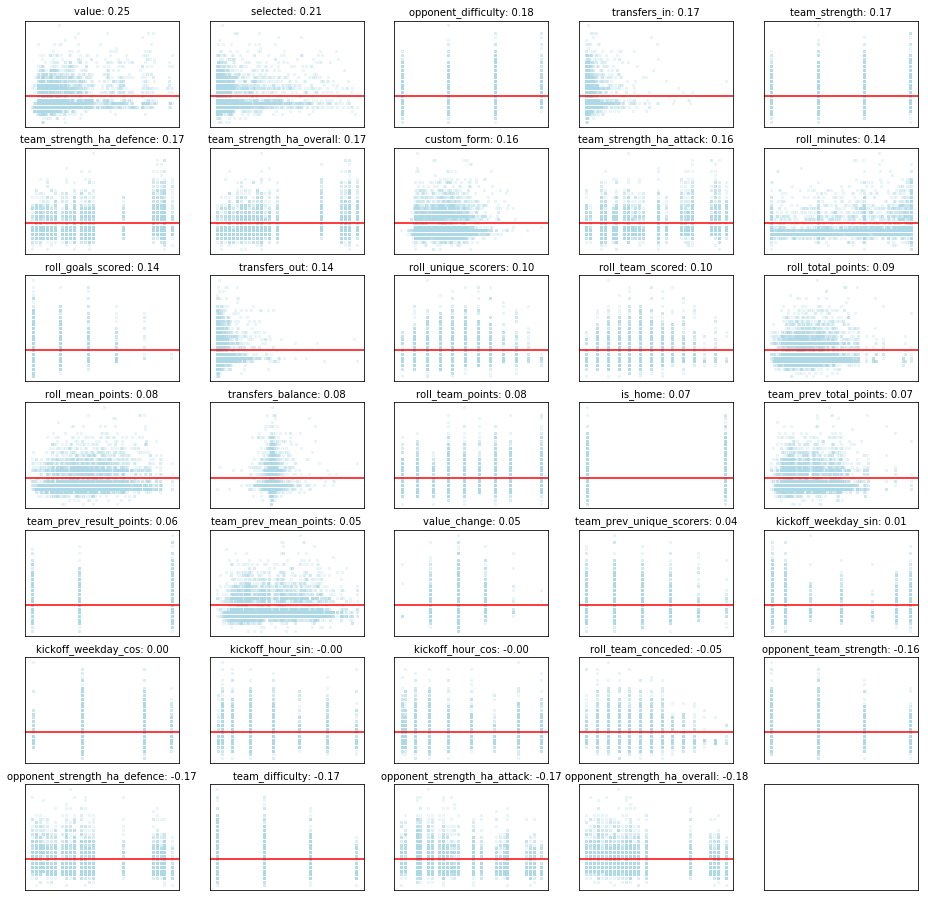

In [26]:
plot_relationships(correlations_with_target.drop('target_total_points'),
                   data_train.loc[(data_train['use_row']) & (data_train['played_at_all'])],
                   feature_cols_rels1,
                   nrows=7,
                   ncols=5)

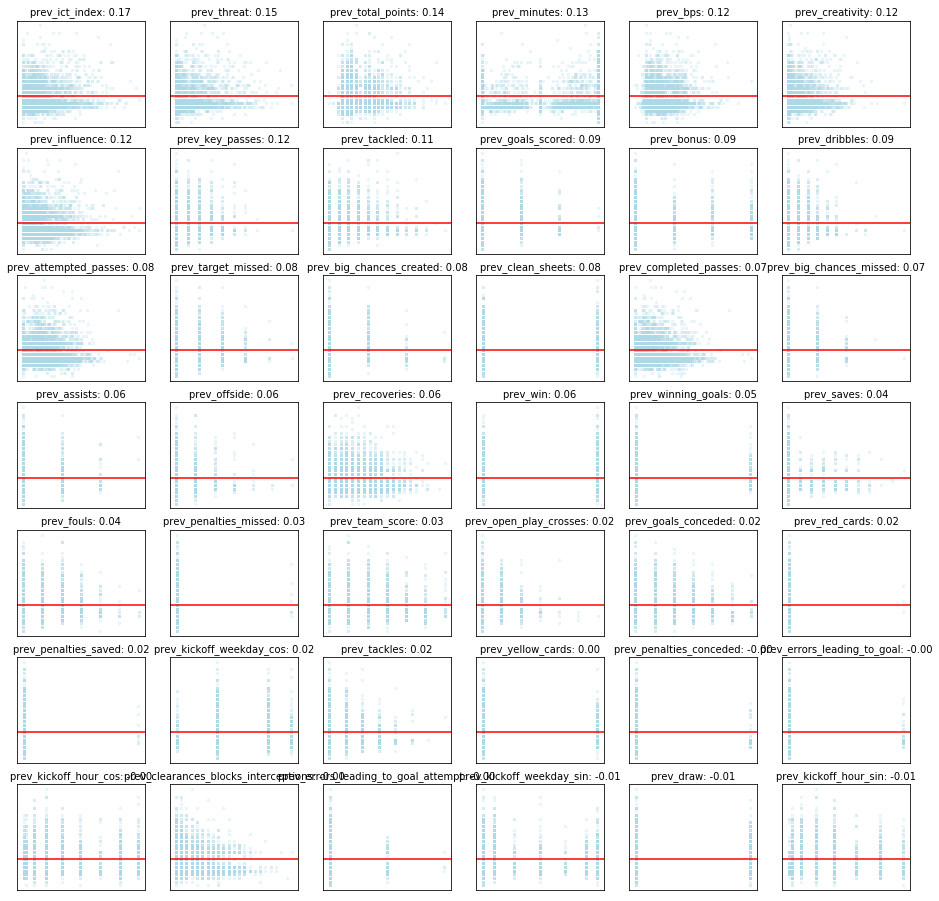

In [27]:
plot_relationships(correlations_with_target.drop('target_total_points'),
                   data_train.loc[(data_train['use_row']) & (data_train['played_at_all'])],
                   feature_cols_rels2,
                   nrows=7,
                   ncols=6)

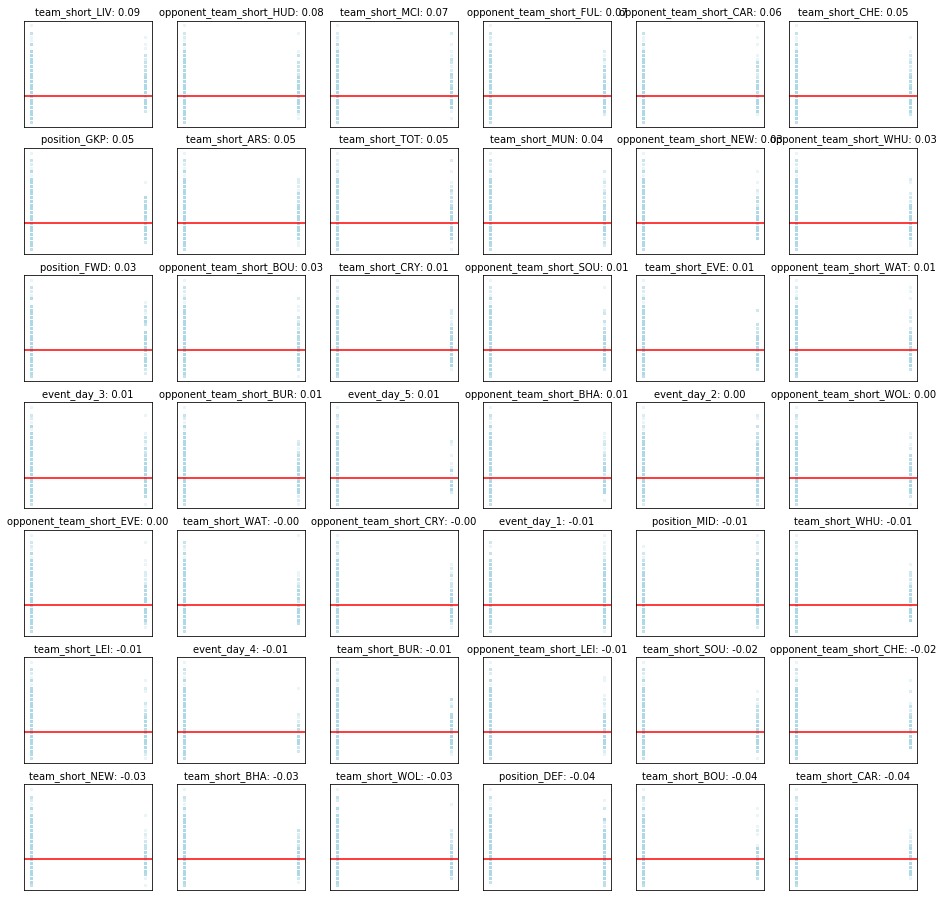

In [28]:
plot_relationships(correlations_with_target.drop('target_total_points'),
                   data_train.loc[(data_train['use_row']) & (data_train['played_at_all'])],
                   feature_cols_rels3,
                   nrows=7,
                   ncols=6)

This might be a challenging problem for a couple or reasons. Firstly, we have a lot of non-linear relationships in our data. We might be able to help with this by taking transforms of our features and response. However, we have negative and zero values for some (including the response), meaning log-transforms for instance will be difficult. Secondly, even if we were to use classification approach, the red reference lines at points=5 do not appear to show any clear separation in the data for any of the features. As a result, we should be aware that our model will be far from perfect! 

## Approach
From the above analysis, we see that this might be a somewhat difficult problem due to the relationships between each feature and the number of points. As a result, my approach will be based around predicting whether five or more points will be scored (unbalanced classification), training on data of players who played in a match. I will make another model for whether a player will play any minutes. If I have time, I will look into performing linear regression to predict the number of points. Alternatively, I might look into some variant of Poisson regression (after attempting to remedy issues such as overdispersion).

With that in mind, let's look at some of the features in more detail and do some cleaning.

In [29]:
data_train['target_gt5'] = data_train['target_total_points'] >= 5
data_val['target_gt5'] = data_val['target_total_points'] >= 5
data_test['target_gt5'] = data_test['target_total_points'] >= 5

# Repeating what was done earlier for the training data on the validation and test. We will not consider rows which do not have
# the full spectrum of data.
data_val['use_row'] = ~data_val['roll_team_scored'].isna()
data_test['use_row'] = ~data_test['roll_team_scored'].isna()

First let's check the number of missing values.

In [30]:
display(data_train.loc[data_train['use_row']].isna().mean().sort_values(ascending=False).head(60))

chance_of_playing_this_round            0.975573
chance_of_playing_next_round            0.975485
status                                  0.969423
news                                    0.969423
target_goals_conceded                   0.030577
target_goals_scored                     0.030577
target_minutes                          0.030577
target_total_points                     0.030577
prev_opponent_score                     0.003515
prev_team_score                         0.003515
prev_errors_leading_to_goal             0.000000
prev_ea_index                           0.000000
prev_influence                          0.000000
prev_dribbles                           0.000000
prev_creativity                         0.000000
prev_completed_passes                   0.000000
prev_clearances_blocks_interceptions    0.000000
prev_clean_sheets                       0.000000
prev_errors_leading_to_goal_attempt     0.000000
prev_fouls                              0.000000
prev_goals_conceded 

Nothing here is too worrying. After some digging about, the prev_opponent_score and prev_team_score missing values come as this data was created in the midst of a double gameweek (where the first game is yet to be played). We can delete these rows. Similarly, the variables with 97% missing are only filled for the latest gameweek (as they are not available historically unless I add them from another dataset). These will not be included in the model. Likewise, the target variables should be missing for the latest gameweek only.

## Add selected variable(s)
During the data preparation there was one additional feature which came to mind which I have not yet added: a more appropriate measure of the number of FPL player teams containing each player. This exists as the variable 'selected', however each gameweek there are different numbers of teams entered into the competition which means that our assumption that each gameweek is considered 'equal' breaks down. While this assumption is imperfect anyway (double gameweeks, player transfers, teams playing in other competitions etc.), over the course of the season the player base increases dramatically. As a result, a 'scaled' version of the selected variable is required. We don't have the weekly player base size so we cannot reconstruct a weekly selected-by percentage.

There are two aproaches which come to mind; I will try both and see which is better related to the response. The reason I have had to wait until now, is that we would otherwise introduce data leakage if we were to perform these approaches on the entire (not just the training) data. Note that if we were to use a more complicated cross validation approach, this would need to be repeated in each fold.

Firstly, calculate the percentiles of the selected variable for each gameweek on the training data only. See which percentile each player gameweek observation fits into based on its selected variable (for each of the train, validation, and test datasets).

In [31]:
class SelectedPercentiles():
    
    def __init__(self, by_group='gameweek', variable='selected'):
        self.by_group = by_group
        self.variable = variable
    
    def fit(self, X):
        self.quants = X.groupby(self.by_group)[self.variable].quantile(
            [0.1*round(i/10, 2) for i in range(100)]).reset_index().rename(columns={'level_1':'percentile',
                                    self.variable:'lower_bound'})
        self.quants['upper_bound'] = self.quants.groupby(self.by_group)['lower_bound'].shift(-1).fillna(99999999)
    
    def transform(self, X, drop_bounds=True):
        X2 = X.copy()
        X2 = X2.merge(self.quants, on=self.by_group)
        X2 = X2[(X2[self.variable] >= X2['lower_bound']) &
                (X2[self.variable] < X2['upper_bound'])]
        if drop_bounds:
            X2.drop(columns=['lower_bound', 'upper_bound'], inplace=True)
        return X2
    
    def fit_transform(self, X, drop_bounds=True):
        self.fit(X)
        return self.transform(X, drop_bounds=drop_bounds)
   

In [32]:
sp = SelectedPercentiles()

data_train = sp.fit_transform(data_train, drop_bounds=True).rename(columns={'percentile': 'selected_percentile'})
data_val = sp.transform(data_val, drop_bounds=True).rename(columns={'percentile': 'selected_percentile'})
data_test = sp.transform(data_test, drop_bounds=True).rename(columns={'percentile': 'selected_percentile'})

The alternative is to simply standardise the selected variable independently for each gameweek. Again, the parameters are derived from the training data only.

In [33]:
def get_std_params(data):
    vals = data.groupby('gameweek')['selected'].agg(['mean','std']).reset_index()
    vals.rename(columns={'mean':'selected_mean',
                         'std':'selected_std'}, inplace=True)
    return vals

gw_selected_stats = get_std_params(data_train)

data_train = data_train.merge(gw_selected_stats, how='left', on='gameweek')
data_train['selected_stand'] = (data_train['selected'] - data_train['selected_mean']) / data_train['selected_std']
data_train.drop(columns=['selected_mean','selected_std'], inplace=True)

data_val = data_val.merge(gw_selected_stats, how='left', on='gameweek')
data_val['selected_stand'] = (data_val['selected'] - data_val['selected_mean']) / data_val['selected_std']
data_val.drop(columns=['selected_mean','selected_std'], inplace=True)

data_test = data_train.merge(gw_selected_stats, how='left', on='gameweek')
data_test['selected_stand'] = (data_test['selected'] - data_test['selected_mean']) / data_test['selected_std']
data_test.drop(columns=['selected_mean','selected_std'], inplace=True)

# Show a few examples for the first players. Include the 'percentile selected' variable for comparison.
data_train.loc[data_train['gameweek']==12,
               ['player_id', 'gameweek', 'selected', 'selected_percentile', 'selected_stand']].head(10)

,player_id,gameweek,selected,selected_percentile,selected_stand
3777,1,12,85826.0,0.70,-0.196766
3778,3,12,5911.0,0.22,-0.424203
3779,4,12,619128.0,0.92,1.321001
3780,6,12,48849.0,0.59,-0.302002
3781,9,12,50590.0,0.60,-0.297047
3782,10,12,6010.0,0.22,-0.423921
3783,11,12,54009.0,0.62,-0.287317
3784,13,12,348419.0,0.89,0.550568
3785,14,12,75940.0,0.67,-0.224902
3786,17,12,208278.0,0.81,0.151730


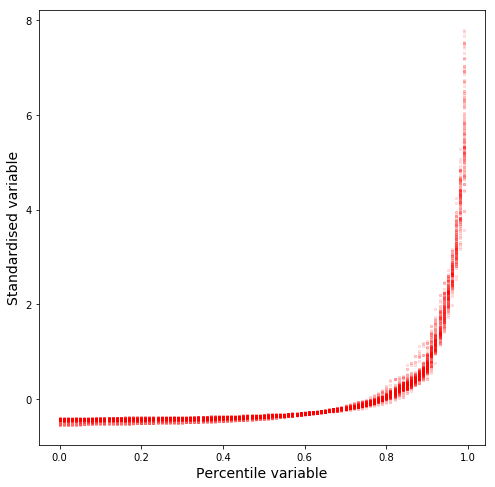

In [34]:
fig, ax = plt.subplots(1, figsize=(8, 8))
data_train.plot.scatter(x='selected_percentile', y='selected_stand', alpha=0.1, s=2, marker='s', color='red', ax=ax)
ax.set_xlabel('Percentile variable', fontsize=14)
ax.set_ylabel('Standardised variable', fontsize=14)
plt.show()

The relationship above for our two newly created variables is likely due to the fact that there are few players which are very popular, with a long tail of players which are rarely selected. In other words our distribution of selected is very positively skewed. As expected (ignoring the discontinous nature of the percentile variable), the relationship is monotonic.

## Analysing outliers
The next step is to attempt to remove any outliers in the data. I will plot box plots for each of the features. Due to the scaling of each feature, I will split the figures depending on the log10 value of each feature's maximum value. This is so features which have values over a short range can be interpreted.

In [35]:
col_maxes = pd.DataFrame(data_train[feature_cols_rels1 +
           feature_cols_rels2 +
           feature_cols_rels3 +
           ['selected_percentile', 'selected_stand']].max().sort_values(ascending=False).astype(float))

col_maxes['log_scale'] = np.where(np.isfinite(col_maxes), np.ceil(np.log10(col_maxes)), 0)

In [36]:
def show_outliers(column_scales, data, logscale):
    features_logscale = list(col_maxes.loc[col_maxes.log_scale == logscale].index)
    if len(features_logscale) > 0:
        fig, ax = plt.subplots(1, figsize=(16, 8))
        data_train.filter(features_logscale, axis=1).boxplot(ax=ax, rot=90)
        plt.title('Log10 scale of {}'.format(logscale), fontsize=14)
        ax.set_xlabel('Feature name', fontsize=14)
        ax.set_ylabel('Values', fontsize=14)
        plt.show()

In [37]:
print('Minimum logscale value: {}'.format(col_maxes['log_scale'].min()))
print('Maximum logscale value: {}'.format(col_maxes['log_scale'].max()))

Minimum logscale value: -0.0
Maximum logscale value: 7.0


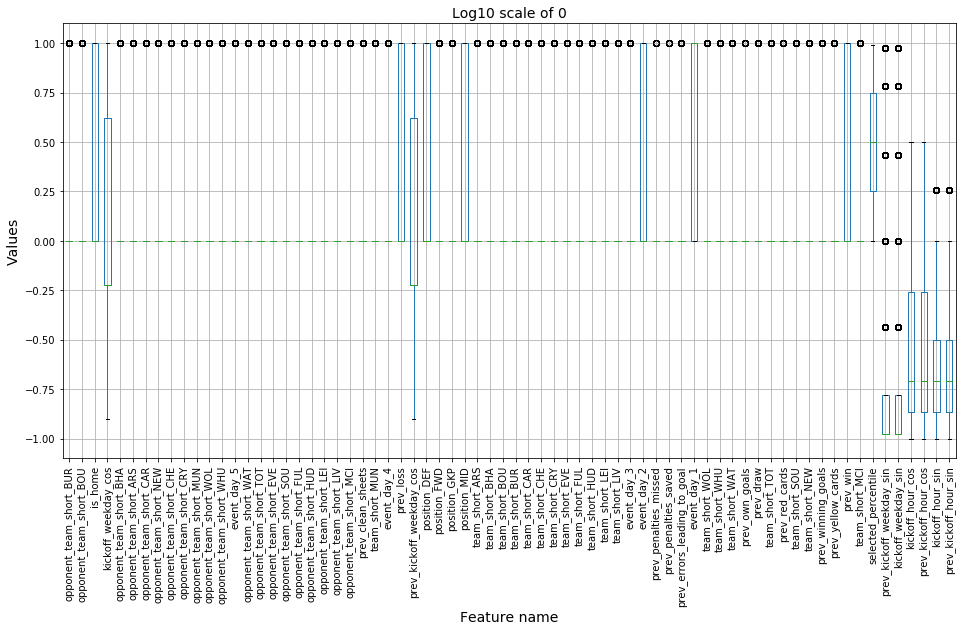

In [38]:
show_outliers(col_maxes, data_train, 0)

For the above, there are no features I am worried about in terms of outliers. Most are binary which means boxplots themselves are less relevant. Those which are not are cyclic features which are always between 1 and -1.

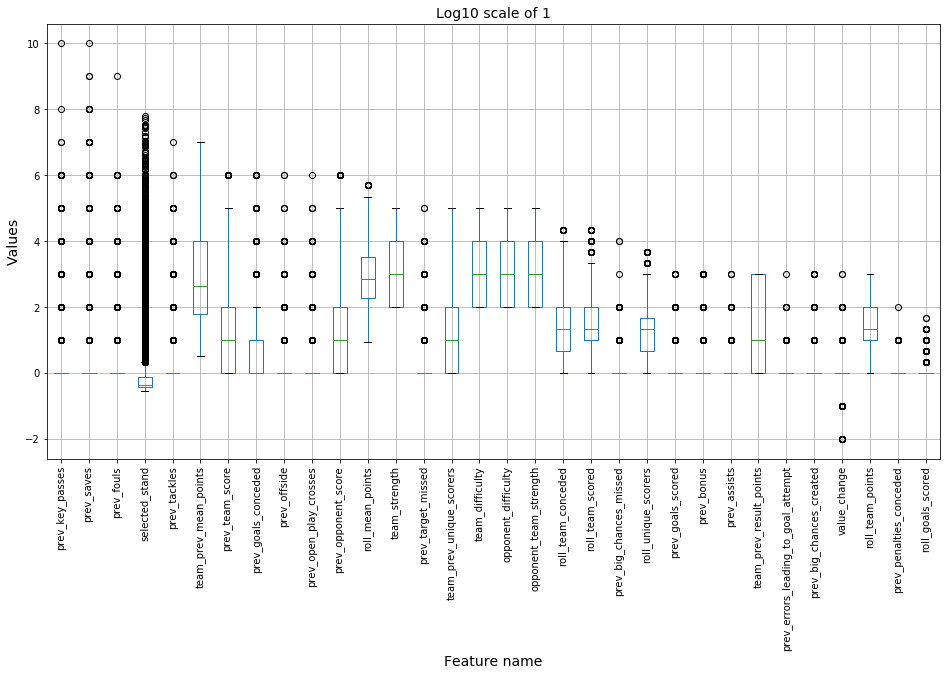

In [39]:
show_outliers(col_maxes, data_train, 1)

For these features, I am also not too worried. They are typically ordinal or discrete counts. Some features' boxplots are very small (around zero) due to the fact that about half of players do not play each game (so their numbers would be zero). If we were to remove these players the results would look better. I will not do this, as I am personally happy to not remove outliers here as these outlier values (for example roll_team_scored: the goals the player's team have been scoring) should be a good indicator of high points scored, rather than any data collection error.

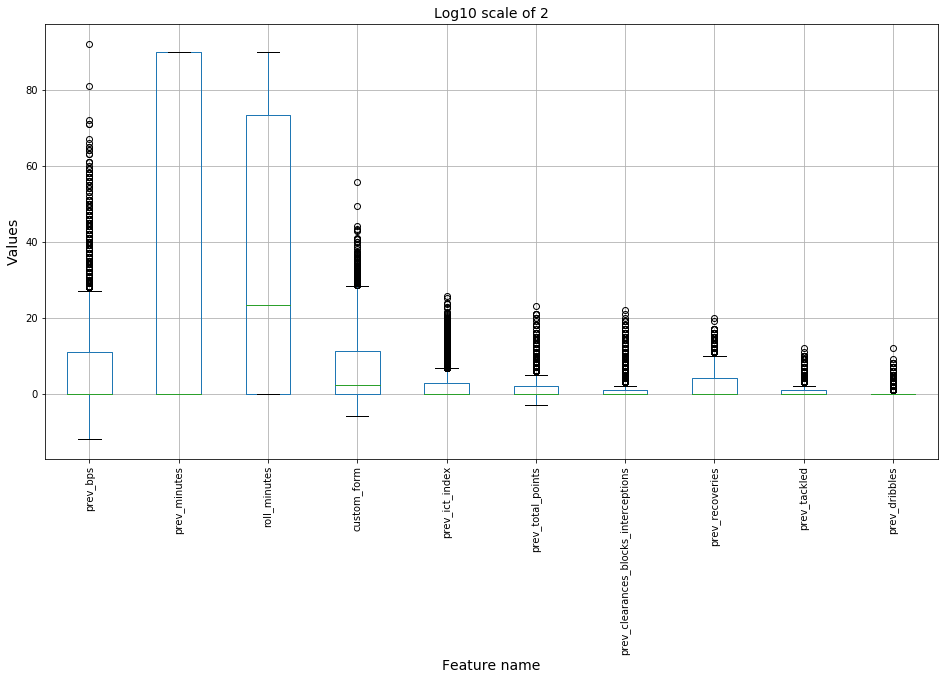

In [40]:
show_outliers(col_maxes, data_train, 2)

These features are similar to the above, where 'outliers' above the box plot would be expected to be beneficial to a model as they may well be good predictors of the number of points scored.

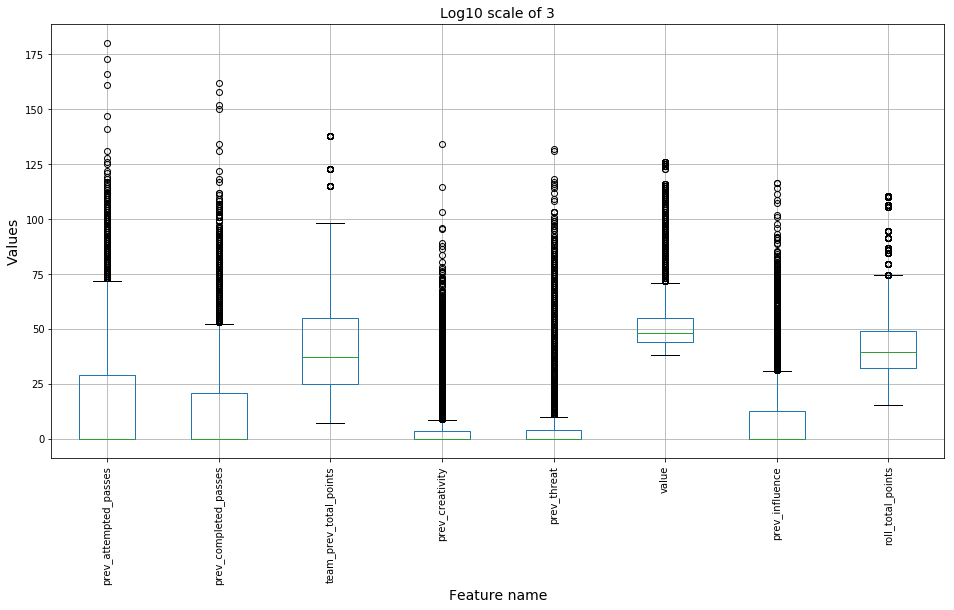

In [41]:
show_outliers(col_maxes, data_train, 3)

Again, this is a similar situation.

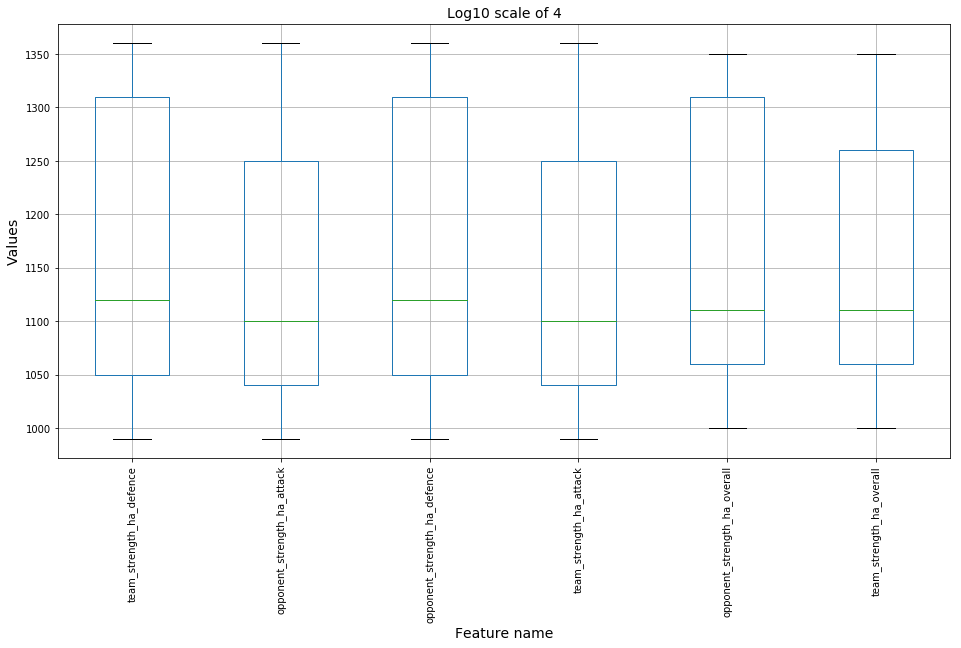

In [42]:
show_outliers(col_maxes, data_train, 4)

And again.

In [43]:
show_outliers(col_maxes, data_train, 5)

In [44]:
show_outliers(col_maxes, data_train, 6)

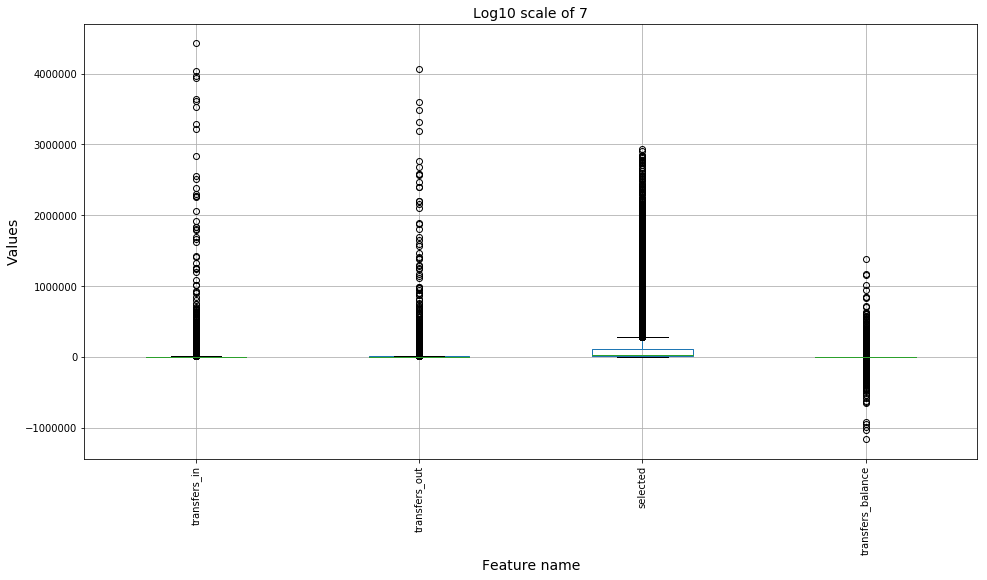

In [45]:
show_outliers(col_maxes, data_train, 7)

Note that most players will not be transferred much as they will either not be playing much (and hence not in anyone's team!), or will not be a fashionable target/player that needs to be got rid of.

My main reason for checking outliers was to ensure there are no erroneous values. This seems not to be the case; outliers appear to normally be from when players have performed well (or badly), which we would expect to be correlated with the target. Again the boxplots above include those players which don't play; in reality they will cover a larger area of the feature space!

## Standardising data
Before continuing, now is a good time to ensure we have data whose features are on the same relative scales. This will reduce bias when fitting many machine learning algorithms. I do this here as we are not using a more complicated cross validation scheme (if we were I would perform this after each fold is created). I will also use this opportunity to make our data numpy arrays rather than pandas DataFrames, which are slightly more easy to use in scikit-learn.

In [46]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

# All the columns we want to use in our data
columns = feature_cols_rels1 + feature_cols_rels2 + feature_cols_rels3 + target_cols

# Reduce the dataframe to the columns we need. Also drop rows with missing values (as shown above these are relatively few)
model_set_train_df = data_train.loc[data_train.use_row, columns].drop(
    columns=['prev_opponent_score', 'prev_team_score']).dropna()

# Final feature names as we have dropped a couple of them due to missing values
columns_in_use_features = [col for col in model_set_train_df.columns if col in 
                           feature_cols_rels1 + feature_cols_rels2 + feature_cols_rels3]
# Standardise the features - return a numpy array
X_train = ss.fit_transform(model_set_train_df.filter(feature_cols_rels1 +
                                                             feature_cols_rels2 +
                                                             feature_cols_rels3, axis=1))

# Our different possible response values. First we will model the latter two binary labels (points above a threshold and whether
# a player plays in a game).
y_train_points = model_set_train_df['target_total_points'].values
y_train_mins = model_set_train_df['target_minutes'].values
y_train_scored = model_set_train_df['target_goals_scored'].values
y_train_conceded = model_set_train_df['target_goals_conceded'].values
y_train_binary_points = y_train_points >= 4
y_train_binary_mins = y_train_mins > 0

# Perform the above (using the fitted standardisation class) for the validation data
model_set_val_df = data_val.loc[data_val.use_row, columns].drop(
    columns=['prev_opponent_score', 'prev_team_score']).dropna()
X_val = ss.transform(model_set_val_df.filter(feature_cols_rels1 +
                                                             feature_cols_rels2 +
                                                             feature_cols_rels3, axis=1))
y_val_points = model_set_val_df['target_total_points'].values
y_val_mins = model_set_val_df['target_minutes'].values
y_val_scored = model_set_val_df['target_goals_scored'].values
y_val_conceded = model_set_val_df['target_goals_conceded'].values
y_val_binary_points = y_val_points >= 4
y_val_binary_mins = y_val_mins > 0

# Perform the above (using the fitted standardisation class) for the test data
model_set_test_df = data_test.loc[data_train.use_row, columns].drop(
    columns=['prev_opponent_score', 'prev_team_score']).dropna()
X_test = ss.transform(model_set_test_df.filter(feature_cols_rels1 +
                                                             feature_cols_rels2 +
                                                             feature_cols_rels3, axis=1))
y_test_points = model_set_test_df['target_total_points'].values
y_test_mins = model_set_test_df['target_minutes'].values
y_test_scored = model_set_test_df['target_goals_scored'].values
y_test_conceded = model_set_test_df['target_goals_conceded'].values
y_test_binary_points = y_test_points >= 4
y_test_binary_mins = y_test_mins > 0

## Assessing correlation amongst features
Another assumption of many algorithms is that features are not overly correlated with each other. In this section I will look at bivariate correlations between features and highlight which may cause the biggest issues.

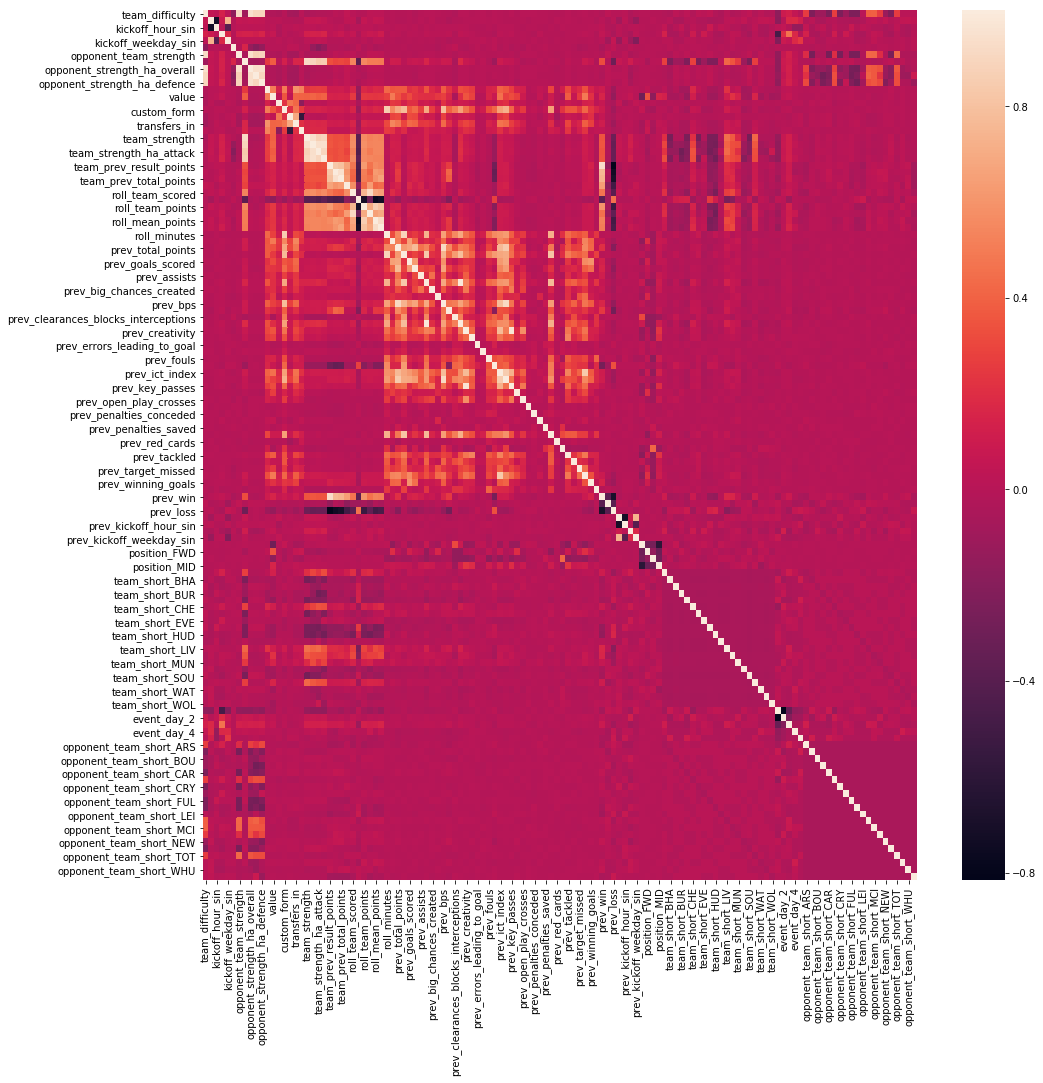

In [47]:
feature_correlation = model_set_train_df[columns_in_use_features].corr()
import seaborn as sns
fig, ax = plt.subplots(1, figsize=(16, 16))
sns.heatmap(feature_correlation, ax=ax)
plt.show()

Here I convert this matrix to a column representation of the pairwise correlations between features.

In [48]:
feature_correlation_long = feature_correlation.stack().reset_index().rename(columns={'level_0': 'feature1',
                                                                                     'level_1': 'feature2',
                                                                                     0: 'correlation_coefficient'})
feature_correlation_long = feature_correlation_long[feature_correlation_long.feature1 != feature_correlation_long.feature2]
feature_correlation_long.sample(10)

,feature1,feature2,correlation_coefficient
11154,team_short_EVE,prev_target_missed,-0.027658
10076,position_GKP,opponent_team_short_TOT,0.005353
405,kickoff_weekday_cos,roll_team_conceded,-0.035149
5509,prev_clean_sheets,team_short_LEI,-0.010657
8787,prev_yellow_cards,team_short_MCI,-0.022265
13620,opponent_team_short_BOU,value,0.010676
7544,prev_penalties_missed,opponent_team_short_CAR,-0.007017
15458,opponent_team_short_TOT,team_short_CHE,0.017237
4811,prev_assists,team_prev_mean_points,0.114329
14419,opponent_team_short_FUL,prev_offside,0.006122


For now, I will use a (somewhat arbitrary) cut-off of 0.8 to find features which are overly correlated with one another.

In [49]:
feature_correlation_overly = feature_correlation_long.loc[np.abs(feature_correlation_long.correlation_coefficient) >= 0.8].copy()
print('Number of overly correlated features: {:.0f}'.format(feature_correlation_overly.shape[0]/2))

# The correlation matrix above is from a square matrix - below I remove duplicate features
# Get both columns and sort the column values for each row
sorted_feature_cols = feature_correlation_overly[['feature1', 'feature2']].values
sorted_feature_cols.sort()
sorted_feature_cols_df = pd.DataFrame(sorted_feature_cols, columns=['feature1a', 'feature1b'])

# Add the two new feature name columns. As their values are ordered, we can easily remove the duplicates
feature_correlation_overly = pd.concat([feature_correlation_overly.reset_index(),
                                       sorted_feature_cols_df.reset_index()],
                                      axis=1, sort=True, join='inner')

feature_correlation_overly.drop_duplicates(subset=['feature1a', 'feature1b'], inplace=True)
display(feature_correlation_overly.drop(columns=['feature1a', 'feature1b', 'index']).sort_values(
    'correlation_coefficient', ascending=False))

Number of overly correlated features: 38


,feature1,feature2,correlation_coefficient
61,prev_attempted_passes,prev_completed_passes,0.989329
65,prev_creativity,prev_key_passes,0.970139
45,team_prev_mean_points,team_prev_total_points,0.949361
15,opponent_strength_ha_overall,opponent_strength_ha_defence,0.946747
1,team_difficulty,opponent_strength_ha_overall,0.945967
32,team_strength_ha_overall,team_strength_ha_defence,0.945503
26,team_strength,team_strength_ha_overall,0.940792
5,opponent_team_strength,opponent_strength_ha_overall,0.938207
14,opponent_strength_ha_overall,opponent_strength_ha_attack,0.937428
31,team_strength_ha_overall,team_strength_ha_attack,0.937012


There are a fair few correlated features. This is an issue and goes against many machine learning algorithm assumptions. The obvious fix is to remove these columns (maybe based upon which of the correlated features has a stronger association with the outcome). However, an alternative would be to use principal component analysis to represent our features in a lower-dimensional space which takes into account variables' correlation. I will use this method as it is more data-driven than manually removing correlated features, and much less complicated than writing an algorithm to do this automatically. We would also not need to specify a cut-off (above 80%) to decide whether a pair of features are overly correlated.

### Principal component analysis

As I have already standardised the data above, we can immediately perform pca.

In [50]:
from sklearn.decomposition import PCA

# Generate the minimum amount of principal components needed to retain at least 95% of the variance in the data
pca = PCA(n_components=0.95, svd_solver='full')

# Fit to the training data and apply to each of the training, validation, and test datasets
pca_train = pca.fit_transform(X_train)
pca_val = pca.transform(X_val)
pca_test = pca.transform(X_test)

print('Features before principal component analysis: {}.'.format(X_train.shape[1]))
print('Features after principal component analysis: {}.'.format(pca_train.shape[1]))

Features before principal component analysis: 127.
Features after principal component analysis: 80.


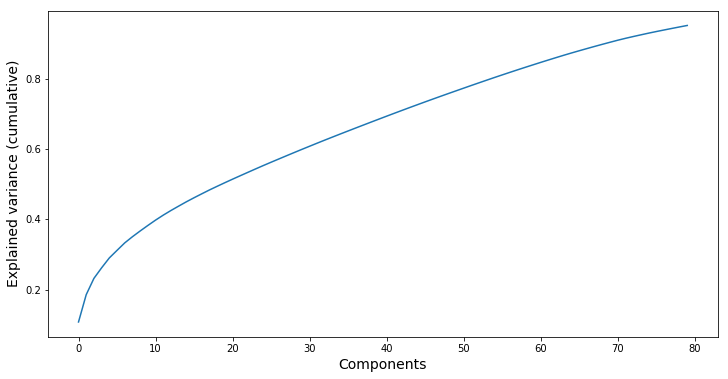

In [51]:
fig, ax = plt.subplots(1, figsize=(12,6))
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set_xlabel('Components', fontsize=14)
ax.set_ylabel('Explained variance (cumulative)', fontsize=14);

# Modelling
As mentioned earlier, the goal of this analysis is to find the players we might want to select for our fantasy football team. There is considerable flexibility in how this can be approached. From the previous analysis, a binary classification of whether a player scores four or more points appears to be a good starting point. To make the problem more tractable I will also create a separate model of whether a player will play or not. As shown earlier, about half of all players will not play in a game. If we combine a value predicting whether a player is likely to play or not with a value for their predicted points assuming they do play, we will easily be able to select good players.

## Predicting whether a player will play
The first model is a simple classification of whether a player is likely to play. As mentioned throughout this notebook, we are using a very simple approach to model evaluation with a single distinct validation set for model comparison and a single distinct set for our final tests. It would be good to perform k-fold cross validation or similar, however, our data contains groups (players across gameweeks) which means creating folds without creating bias will be tricky. Scikit-learn does offer some functionality for grouped data so at some point I may come back and improve this process. For now, the separate data splits should allow for relatively unbiased model performance estimates. I will train on the training set a variety of different models with different hyperparameters (here using `GridSearchCV` would be handy if I were using cross validation), and compare using the results of the validation set.

First I will confirm the balance in the training data:

In [52]:
print(f"Percentage of player rows playing in the row's game {np.mean(y_train_binary_mins):.1%}")

Percentage of player rows playing in the row's game 47.9%


This looks pretty balanced. Now time to try several models including:
* logistic regression
* decision tree
* random forest
* adaptive boosting
* svm
* k-nearest neigbours

For my evaluation metric I will simply use accuracy due to the dataset balance.

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.pipeline import Pipeline

# So we can use GridSearchCV, we set our validation set to be used as the hold out set in a single fold of the cross validation
# Recombine train and validation X and y, but keep a record of split in 'test_fold'
test_fold = [-1 for i in range(X_train.shape[0])] + [0 for i in range(X_val.shape[0])]
search_X = np.concatenate((X_train, X_val))
search_y = np.concatenate((y_train_binary_mins, y_val_binary_mins))

# Tell GridSearchCV which data to use as validation
ps = PredefinedSplit(test_fold=test_fold)

# Construct a pipeline with one model (merely a placeholder)
pipeline = Pipeline([('clf', LogisticRegression())])

# Hyperparameter grid to search over for each classifier
search_space = [
                {'clf': [LogisticRegression()],
                'clf__penalty': ['l1', 'l2'],
                'clf__C': np.logspace(0, 4, 5)
                },
               {'clf': [DecisionTreeClassifier()],
                'clf__max_depth': np.linspace(1, 20, 20),
                'clf__min_samples_split': np.linspace(0.1, 1, 10),
                'clf__max_features': ['auto', 'log2']
               },
               {'clf': [RandomForestClassifier()],
                'clf__n_estimators': [2, 5, 10, 50, 100, 250, 500, 1000],
                'clf__max_depth': np.linspace(1, 10, 10),
                #'clf__min_samples_split': np.linspace(0.1, 1, 10),
                'clf__max_features': ['auto', 'log2']
               },
               {'clf': [AdaBoostClassifier()],
                'clf__n_estimators':[2, 5, 10, 50, 100, 250, 500, 1000]
               },
               {'clf': [SVC()],
               'clf__C': np.logspace(-3, 1, 5),
               'clf__gamma': np.logspace(-3, 0, 4),
               'clf__kernel': ['linear', 'rbf']
               },
               {'clf': [KNeighborsClassifier()],
               'clf__n_neighbors': [1, 5, 10, 20, 50]
               }
               ]

classifiers = GridSearchCV(pipeline, search_space, cv=ps, verbose=10)

In [54]:
# Can take a while with the above hyperparameter grid (~44mins)
models_minutes = classifiers.fit(search_X, search_y)

Fitting 1 folds for each of 623 candidates, totalling 623 fits
[CV] clf=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=1.0, clf__penalty=l1 
[CV]  clf=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=1.0, clf__penalty=l1, score=0.8088872832369942, total=   1.1s
[CV] clf=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=1.0, c

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV]  clf=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=1.0, clf__penalty=l2, score=0.8081647398843931, total=   0.8s
[CV] clf=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=10.0, clf__penalty=l1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


[CV]  clf=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=10.0, clf__penalty=l1, score=0.8078034682080925, total=   2.1s
[CV] clf=LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=10.0, clf__penalty=l2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.3s remaining:    0.0s


[CV]  clf=LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=10.0, clf__penalty=l2, score=0.8085260115606936, total=   1.8s
[CV] clf=LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=100.0, clf__penalty=l1 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    6.2s remaining:    0.0s


[CV]  clf=LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=100.0, clf__penalty=l1, score=0.8078034682080925, total=   2.3s
[CV] clf=LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=100.0, clf__penalty=l2 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.6s remaining:    0.0s


[CV]  clf=LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=100.0, clf__penalty=l2, score=0.8085260115606936, total=   1.8s
[CV] clf=LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=1000.0, clf__penalty=l1 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   10.5s remaining:    0.0s


[CV]  clf=LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=1000.0, clf__penalty=l1, score=0.8078034682080925, total=   2.5s
[CV] clf=LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), clf__C=1000.0, clf__penalty=l2 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   13.1s remaining:    0.0s


[CV]  clf=LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), clf__C=1000.0, clf__penalty=l2, score=0.8081647398843931, total=   1.9s
[CV] clf=LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), clf__C=10000.0, clf__penalty=l1 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   15.1s remaining:    0.0s


[CV]  clf=LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), clf__C=10000.0, clf__penalty=l1, score=0.8081647398843931, total=   7.1s
[CV] clf=LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), clf__C=10000.0, clf__penalty=l2 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   22.4s remaining:    0.0s


[CV]  clf=LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), clf__C=10000.0, clf__penalty=l2, score=0.8081647398843931, total=   2.3s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=1.0, clf__max_features=auto, clf__min_samples_split=0.1 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            m

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=1.0, clf__max_features=auto, clf__min_samples_split=0.9, score=0.8204479768786127, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.9,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=1.0, clf__max_features=auto, clf__min_samples_split=1.0 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1.0,
    

KeyboardInterrupt: 

In [ ]:
import pickle
outpath = r'D:\Documents\PythonDoc\FantasyFootball\models\minutes'
outname = 'minutes_gridsearch.pkl'

with open(os.path.join(outpath, outname), 'wb') as f:
    pickle.dump(models_minutes, f)

In [55]:
import pickle

inpath = r'D:\Documents\PythonDoc\FantasyFootball\models\minutes'
inname = 'minutes_gridsearch.pkl'

with open(os.path.join(inpath, inname), 'rb') as f:
    models_minutes = pickle.load(f)

In [56]:
models_minutes.best_estimator_.get_params

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10.0, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])>

In [57]:
pred_mins_test = models_minutes.predict(X_test)
print('acc: {}'.format(accuracy_score(y_test_binary_mins, pred_mins_test)))

acc: 0.8674884437596302


In [58]:
#full_results_minutes = pd.DataFrame(models_minutes.cv_results_)
best_model_mins = models_minutes.best_params_['clf']
y_train_pred_binary_mins = best_model_mins.predict(X_train)
y_val_pred_binary_mins = best_model_mins.predict(X_val)
y_test_pred_binary_mins = best_model_mins.predict(X_test)

y_train_pred_binary_mins_prob = best_model_mins.predict_proba(X_train)[:,1]
y_val_pred_binary_mins_prob = best_model_mins.predict_proba(X_val)[:,1]
y_test_pred_binary_mins_prob = best_model_mins.predict_proba(X_test)[:,1]

## Predicting player points
As we have generated the above prediction of whether a player will play or not, we will only consider those players which have played when we build our point prediction model. This is because our goal is to use our results to decide upon the players we should have in our team for the next gameweek. If we frame our problem as 'how many points will each player play **assuming they play**' there are not issues, as we can use our above prediction to filter to those likely to play.

### Classification approach
This serves the purpose of reducing the imbalance in our data.


In [59]:
from sklearn.metrics import roc_curve, make_scorer

X_train_played = X_train[y_train_binary_mins]
y_train_played = y_train_binary_points[y_train_binary_mins]

X_val_played = X_val[y_val_binary_mins]
y_val_played = y_val_binary_points[y_val_binary_mins]

X_test_played = X_test[y_test_binary_mins]
y_test_played = y_test_binary_points[y_test_binary_mins]

print(f"Percentage of player rows getting more than four points {np.mean(y_train_played):.1%}")

Percentage of player rows getting more than four points 24.7%


This is not too imbalanced. Whilst I will not resample the data, I will switch my model evaluation metric to be the ROC area under the curve, which is invariant to classification thresholds and generally is more useful in cases with a minority class.

ROC AUC on training: 0.73
ROC AUC on validation: 0.69


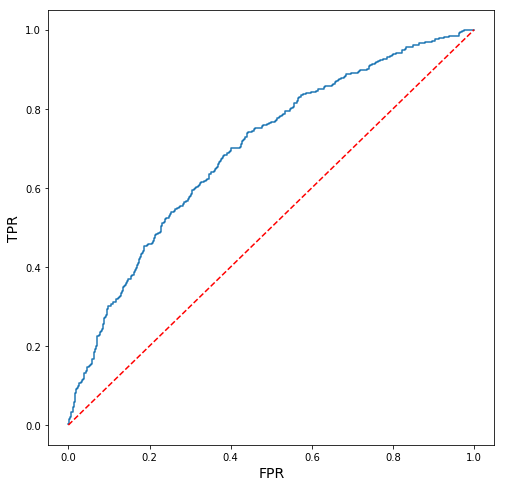

In [60]:
# So we can use GridSearchCV, we set our validation set to be used as the hold out set in a single fold of the cross validation
# Recombine train and validation X and y, but keep a record of split in 'test_fold'
test_fold_pts = [-1 for i in range(X_train_played.shape[0])] + [0 for i in range(X_val_played.shape[0])]
search_X_pts = np.concatenate((X_train_played, X_val_played))
search_y_pts = np.concatenate((y_train_played, y_val_played))

lr = LogisticRegression()

lr.fit(X_train_played, y_train_played)

preds_p_train = lr.predict_proba(X_train_played)[:, 1]
preds_p_val = lr.predict_proba(X_val_played)[:, 1]

print('ROC AUC on training: {:.2f}'.format(roc_auc_score(y_train_played, preds_p_train)))
print('ROC AUC on validation: {:.2f}'.format(roc_auc_score(y_val_played, preds_p_val)))
fpr, tpr, thresholds = roc_curve(y_val_played, preds_p_val)

fig, ax = plt.subplots(1, figsize=(8, 8))
ax.plot(fpr, tpr)
ax.plot(np.linspace(0, 1, 11), np.linspace(0, 1, 11), '--', color='r')
ax.set_xlabel('FPR', fontsize=14)
ax.set_ylabel('TPR', fontsize=14)
plt.show()

In [86]:
# Tell GridSearchCV which data to use as validation
ps_pts = PredefinedSplit(test_fold=test_fold_pts)

# Construct a pipeline with one model (merely a placeholder)
pipeline_pts = Pipeline([('clf', LogisticRegression())])

# Hyperparameter grid to search over for each classifier
search_space_pts = [
                {'clf': [LogisticRegression()],
                'clf__penalty': ['l1', 'l2'],
                'clf__C': np.logspace(0, 4, 5)
                },
               {'clf': [DecisionTreeClassifier()],
                'clf__max_depth': np.linspace(1, 20, 20),
                'clf__min_samples_split': np.linspace(0.1, 1, 10),
                'clf__max_features': ['auto', 'log2']
               },
               {'clf': [RandomForestClassifier()],
                'clf__n_estimators': [2, 5, 10, 50, 100, 250, 500, 1000],
                'clf__max_depth': np.linspace(1, 10, 10),
                #'clf__min_samples_split': np.linspace(0.1, 1, 10),
                'clf__max_features': ['auto', 'log2']
               },
               {'clf': [AdaBoostClassifier()],
                'clf__n_estimators':[2, 5, 10, 50, 100, 250, 500, 1000]
               },
#                {'clf': [SVC()],
#                'clf__C': np.logspace(-3, 1, 5),
#                'clf__gamma': np.logspace(-3, 0, 4),
#                'clf__kernel': ['linear', 'rbf']
#                },
               {'clf': [KNeighborsClassifier()],
               'clf__n_neighbors': [1, 5, 10, 20, 50]
               }
               ]

classifiers_pts = GridSearchCV(pipeline_pts, search_space_pts, cv=ps_pts, verbose=10, scoring='roc_auc')

# roc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
#                              needs_threshold=True)

models_pts = classifiers_pts.fit(search_X_pts, search_y_pts)

Fitting 1 folds for each of 583 candidates, totalling 583 fits
[CV] clf=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=1.0, clf__penalty=l1 
[CV]  clf=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=1.0, clf__penalty=l1, score=0.7042133476279819, total=   4.1s
[CV] clf=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=1.0, c

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.1s remaining:    0.0s


[CV]  clf=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=1.0, clf__penalty=l2, score=0.7044974537657464, total=   0.6s
[CV] clf=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=10.0, clf__penalty=l1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.8s remaining:    0.0s


[CV]  clf=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=10.0, clf__penalty=l1, score=0.7046314660948807, total=  27.9s
[CV] clf=LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=10.0, clf__penalty=l2 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.8s remaining:    0.0s


[CV]  clf=LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=10.0, clf__penalty=l2, score=0.7046663093004556, total=   0.8s
[CV] clf=LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=100.0, clf__penalty=l1 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   33.7s remaining:    0.0s


[CV]  clf=LogisticRegression(C=10.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=100.0, clf__penalty=l1, score=0.704406325381935, total=  41.4s
[CV] clf=LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=100.0, clf__penalty=l2 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s


[CV]  clf=LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=100.0, clf__penalty=l2, score=0.7043285982310372, total=   1.1s
[CV] clf=LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=1000.0, clf__penalty=l1 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.3min remaining:    0.0s


[CV]  clf=LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), clf__C=1000.0, clf__penalty=l1, score=0.7045269364781559, total=  26.3s
[CV] clf=LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), clf__C=1000.0, clf__penalty=l2 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.7min remaining:    0.0s


[CV]  clf=LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), clf__C=1000.0, clf__penalty=l2, score=0.704245510586974, total=   1.5s
[CV] clf=LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), clf__C=10000.0, clf__penalty=l1 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.7min remaining:    0.0s


[CV]  clf=LogisticRegression(C=1000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), clf__C=10000.0, clf__penalty=l1, score=0.7045483784508175, total=  26.7s
[CV] clf=LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), clf__C=10000.0, clf__penalty=l2 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.2min remaining:    0.0s


[CV]  clf=LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False), clf__C=10000.0, clf__penalty=l2, score=0.7042267488608953, total=   1.6s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=1.0, clf__max_features=auto, clf__min_samples_split=0.1 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            m

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.6,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=1.0, clf__max_features=log2, clf__min_samples_split=0.7000000000000001, score=0.5481747520771911, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.7000000000000001,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=1.0, clf__max_features=log2, clf__min_samples_split=0.8 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criteri

            splitter='best'), clf__max_depth=2.0, clf__max_features=auto, clf__min_samples_split=0.6, score=0.5737818279281695, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.6,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=2.0, clf__max_features=auto, clf__min_samples_split=0.7000000000000001 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.6,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=2.0, clf__max_features=auto, 

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.6,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=2.0, clf__max_features=log2, clf__min_samples_split=0.7000000000000001, score=0.5249356740820156, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.7000000000000001,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=2.0, clf__max_features=log2, clf__min_samples_split=0.8 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criteri

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.6,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=3.0, clf__max_features=auto, clf__min_samples_split=0.7000000000000001, score=0.549863307424283, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.7000000000000001,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=3.0, clf__max_features=auto, clf__min_samples_split=0.8 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterio

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=3.0, clf__max_features=log2, clf__min_samples_split=0.6, score=0.5753417314392925, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.6,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=3.0, clf__max_features=log2, clf__min_samples_split=0.7000000000000001 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=4.0, clf__max_features=auto, clf__min_samples_split=0.9, score=0.5436210131332083, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.9,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=4.0, clf__max_features=auto, clf__min_samples_split=1.0 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4.0,
    

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.1,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=5.0, clf__max_features=auto, clf__min_samples_split=0.2, score=0.6609220048244439, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=5.0, clf__max_features=auto, clf__min_samples_split=0.30000000000000004 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=5.0, clf__max_features=log2, clf__min_samples_split=0.5, score=0.6003296703296703, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=5.0, clf__max_features=log2, clf__min_samples_split=0.6 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5.0,
    

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.7000000000000001,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=6.0, clf__max_features=auto, clf__min_samples_split=0.8, score=0.5856392388099705, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=6.0, clf__max_features=auto, clf__min_samples_split=0.9 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=1.0,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=7.0, clf__max_features=auto, clf__min_samples_split=0.1, score=0.6418346287858483, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.1,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=7.0, clf__max_features=auto, clf__min_samples_split=0.2 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7.0,
    

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.30000000000000004,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=7.0, clf__max_features=log2, clf__min_samples_split=0.4, score=0.5961471455373895, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=7.0, clf__max_features=log2, clf__min_samples_split=0.5 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max

            splitter='best'), clf__max_depth=8.0, clf__max_features=auto, clf__min_samples_split=0.7000000000000001, score=0.5377700348432056, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.7000000000000001,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=8.0, clf__max_features=auto, clf__min_samples_split=0.8 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.7000000000000001,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=1.0,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=9.0, clf__max_features=auto, clf__min_samples_split=0.1, score=0.639343339587242, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.1,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=9.0, clf__max_features=auto, clf__min_samples_split=0.2 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9.0,
     

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=9.0, clf__max_features=log2, clf__min_samples_split=0.30000000000000004, score=0.5831318681318682, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.30000000000000004,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=9.0, clf__max_features=log2, clf__min_samples_split=0.4 
[CV]  clf=DecisionTreeClassifier(class_weight=None, crite

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.30000000000000004,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=10.0, clf__max_features=auto, clf__min_samples_split=0.4, score=0.5788126507638702, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=10.0, clf__max_features=auto, clf__min_samples_split=0.5 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini',

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=10.0, clf__max_features=log2, clf__min_samples_split=0.6, score=0.5730152774055213, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.6,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=10.0, clf__max_features=log2, clf__min_samples_split=0.7000000000000001 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', 

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.7000000000000001,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=11.0, clf__max_features=auto, clf__min_samples_split=0.8, score=0.549863307424283, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=11.0, clf__max_features=auto, clf__min_samples_split=0.9 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', m

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=1.0,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=12.0, clf__max_features=auto, clf__min_samples_split=0.1, score=0.613154650227821, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.1,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=12.0, clf__max_features=auto, clf__min_samples_split=0.2 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12.0,


[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=12.0, clf__max_features=log2, clf__min_samples_split=0.30000000000000004, score=0.6082417582417582, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=12.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.30000000000000004,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=12.0, clf__max_features=log2, clf__min_samples_split=0.4 
[CV]  clf=DecisionTreeClassifier(class_weight=None, c

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=13.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.30000000000000004,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=13.0, clf__max_features=auto, clf__min_samples_split=0.4, score=0.6094773519163763, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=13.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=13.0, clf__max_features=auto, clf__min_samples_split=0.5 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini',

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=13.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.6,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=13.0, clf__max_features=log2, clf__min_samples_split=0.7000000000000001, score=0.5618386491557223, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=13.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.7000000000000001,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=13.0, clf__max_features=log2, clf__min_samples_split=0.8 
[CV]  clf=DecisionTreeClassifier(class_weight=None, cri

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=14.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.9,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=14.0, clf__max_features=auto, clf__min_samples_split=1.0, score=0.5856392388099705, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=14.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=1.0,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=14.0, clf__max_features=log2, clf__min_samples_split=0.1 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=14.0,

            splitter='best'), clf__max_depth=15.0, clf__max_features=auto, clf__min_samples_split=0.2, score=0.6198298043419994, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=15.0, clf__max_features=auto, clf__min_samples_split=0.30000000000000004 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=15.0, clf__max_features=

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.30000000000000004,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=15.0, clf__max_features=log2, clf__min_samples_split=0.4, score=0.5775180916644331, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=15.0, clf__max_features=log2, clf__min_samples_split=0.5 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini',

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=16.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=16.0, clf__max_features=auto, clf__min_samples_split=0.6, score=0.5665786652372018, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=16.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.6,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=16.0, clf__max_features=auto, clf__min_samples_split=0.7000000000000001 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', 

            splitter='best'), clf__max_depth=17.0, clf__max_features=auto, clf__min_samples_split=0.2, score=0.6285298847493969, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=17.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=17.0, clf__max_features=auto, clf__min_samples_split=0.30000000000000004 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=17.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=17.0, clf__max_features=

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=17.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.30000000000000004,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=17.0, clf__max_features=log2, clf__min_samples_split=0.4, score=0.5915424819083356, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=17.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=17.0, clf__max_features=log2, clf__min_samples_split=0.5 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini',

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=18.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=18.0, clf__max_features=auto, clf__min_samples_split=0.30000000000000004, score=0.6006633610292147, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=18.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.30000000000000004,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=18.0, clf__max_features=auto, clf__min_samples_split=0.4 
[CV]  clf=DecisionTreeClassifier(class_weight=None, c

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=18.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=18.0, clf__max_features=log2, clf__min_samples_split=0.30000000000000004, score=0.6086558563387832, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=18.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.30000000000000004,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=18.0, clf__max_features=log2, clf__min_samples_split=0.4 
[CV]  clf=DecisionTreeClassifier(class_weight=None, c

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=19.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=19.0, clf__max_features=auto, clf__min_samples_split=0.5, score=0.5787188421334762, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=19.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=19.0, clf__max_features=auto, clf__min_samples_split=0.6 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=19.0,

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=19.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.6,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=19.0, clf__max_features=log2, clf__min_samples_split=0.7000000000000001, score=0.579308496381667, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=19.0,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.7000000000000001,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=19.0, clf__max_features=log2, clf__min_samples_split=0.8 
[CV]  clf=DecisionTreeClassifier(class_weight=None, crit

[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=0.9,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=20.0, clf__max_features=auto, clf__min_samples_split=1.0, score=0.5856392388099705, total=   0.0s
[CV] clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20.0,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=1.0,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), clf__max_depth=20.0, clf__max_features=log2, clf__min_samples_split=0.1 
[CV]  clf=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20.0,

            warm_start=False), clf__max_depth=1.0, clf__max_features=auto, clf__n_estimators=5, score=0.6062583757705708, total=   0.0s
[CV] clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1.0, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=1.0, clf__max_features=auto, clf__n_estimators=10 
[CV]  clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1.0, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, 

[CV]  clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1.0, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=1.0, clf__max_features=log2, clf__n_estimators=100, score=0.642979094076655, total=   0.1s
[CV] clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1.0, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=1.0, clf__max_fea

[CV]  clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2.0, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=2.0, clf__max_features=auto, clf__n_estimators=100, score=0.6583007236665772, total=   0.2s
[CV] clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2.0, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=2.0, clf__max_fe

[CV]  clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2.0, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=2.0, clf__max_features=log2, clf__n_estimators=100, score=0.6507611900294827, total=   0.1s
[CV] clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2.0, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=2.0, clf__max_fe

[CV]  clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3.0, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=3.0, clf__max_features=auto, clf__n_estimators=100, score=0.662771374966497, total=   0.2s
[CV] clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3.0, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=3.0, clf__max_fea

[CV]  clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3.0, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=3.0, clf__max_features=log2, clf__n_estimators=100, score=0.6596006432591799, total=   0.1s
[CV] clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3.0, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=3.0, clf__max_fe

[CV]  clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4.0, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=4.0, clf__max_features=auto, clf__n_estimators=100, score=0.6784454569820424, total=   0.3s
[CV] clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4.0, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=4.0, clf__max_fe

[CV]  clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4.0, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=4.0, clf__max_features=log2, clf__n_estimators=100, score=0.6744036451353523, total=   0.3s
[CV] clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4.0, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=4.0, clf__max_fe

[CV]  clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5.0, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=5.0, clf__max_features=auto, clf__n_estimators=100, score=0.6900589654248193, total=   0.3s
[CV] clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5.0, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=5.0, clf__max_fe

[CV]  clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5.0, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=5.0, clf__max_features=log2, clf__n_estimators=100, score=0.6825167515411419, total=   0.2s
[CV] clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5.0, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=5.0, clf__max_fe

[CV]  clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6.0, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=6.0, clf__max_features=auto, clf__n_estimators=100, score=0.6987670865719646, total=   0.4s
[CV] clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6.0, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=6.0, clf__max_fe

[CV]  clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6.0, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=6.0, clf__max_features=log2, clf__n_estimators=100, score=0.692267488608952, total=   0.2s
[CV] clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6.0, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=6.0, clf__max_fea

[CV]  clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7.0, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=7.0, clf__max_features=auto, clf__n_estimators=100, score=0.7161860091128384, total=   0.5s
[CV] clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7.0, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=7.0, clf__max_fe

[CV]  clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7.0, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=7.0, clf__max_features=log2, clf__n_estimators=100, score=0.7047788796569284, total=   0.3s
[CV] clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7.0, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=7.0, clf__max_fe

[CV]  clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8.0, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=8.0, clf__max_features=auto, clf__n_estimators=100, score=0.7112221924417046, total=   0.5s
[CV] clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8.0, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=8.0, clf__max_fe

[CV]  clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8.0, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=8.0, clf__max_features=log2, clf__n_estimators=100, score=0.7126856070758509, total=   0.4s
[CV] clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8.0, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=8.0, clf__max_fe

[CV]  clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9.0, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=9.0, clf__max_features=auto, clf__n_estimators=100, score=0.7272581077459126, total=   0.6s
[CV] clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9.0, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=9.0, clf__max_fe

[CV]  clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9.0, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=9.0, clf__max_features=log2, clf__n_estimators=100, score=0.7258295363173412, total=   0.4s
[CV] clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9.0, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=9.0, clf__max_fe

[CV]  clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10.0, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=10.0, clf__max_features=auto, clf__n_estimators=100, score=0.7307075850978291, total=   0.7s
[CV] clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10.0, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=10.0, clf__ma

[CV]  clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10.0, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=10.0, clf__max_features=log2, clf__n_estimators=100, score=0.7221790404717234, total=   0.4s
[CV] clf=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10.0, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False), clf__max_depth=10.0, clf__ma

[CV]  clf=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform'), clf__n_neighbors=50, score=0.6850361833288663, total=   1.5s


[Parallel(n_jobs=1)]: Done 583 out of 583 | elapsed:  6.3min finished


In [87]:
import pickle
outpath = r'D:\Documents\PythonDoc\FantasyFootball\models\points'
outname = 'points_binary_gridsearch.pkl'

with open(os.path.join(outpath, outname), 'wb') as f:
    pickle.dump(models_pts, f)

In [108]:
display(models_pts.best_estimator_.get_params)

pred_pts_test = models_pts.predict(X_test_played)
print('\n\nroc auc: {}'.format(roc_auc_score(y_test_played, pred_pts_test)))

best_model_pts = models_pts.best_params_['clf']
y_train_pred_binary_pts = best_model_pts.predict(X_train_played)
y_val_pred_binary_pts = best_model_pts.predict(X_val_played)
y_test_pred_binary_pts = best_model_pts.predict(X_test_played)

y_train_pred_binary_pts_prob = best_model_pts.predict_proba(X_train_played)[:,1]
y_val_pred_binary_pts_prob = best_model_pts.predict_proba(X_val_played)[:,1]
y_test_pred_binary_pts_prob = best_model_pts.predict_proba(X_test_played)[:,1]

<bound method Pipeline.get_params of Pipeline(memory=None,
     steps=[('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10.0, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])>



roc auc: 0.7088751614719617


In [117]:
from sklearn.metrics import recall_score

cm_pts = confusion_matrix(y_test_played, y_test_pred_binary_pts_prob>0.35)
display(cm_pts)

print('Using a threshold of 0.35, the accuracy on the test set: {:.2f}'.format(
    accuracy_score(y_test_played, y_test_pred_binary_pts_prob>0.35)))
print('Using a threshold of 0.35, the recall on the test set: {:.2f}'.format(
    recall_score(y_test_played, y_test_pred_binary_pts_prob>0.35)))

array([[3839,  151],
       [ 317, 1045]], dtype=int64)

Using a threshold of 0.35, the accuracy on the test set: 0.91
Using a threshold of 0.35, the recall on the test set: 0.77


### Regression approach

## Balancing data/over/under-sampling